In [1]:
# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime
import hashlib

# Scientific computing
import numpy as np
import scipy as sp

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import (
    DataLoader, Dataset, TensorDataset,
    random_split, ConcatDataset
)
from torchvision import transforms

# Neural operator specific
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer, LpLoss, H1Loss

# Data processing and visualization
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Progress tracking
from tqdm import tqdm

In [2]:
# Force garbage collection to release file handles
import gc
gc.collect()

291

## Load and visualize data

In [2]:
current_dir = os.getcwd()
reduced_dataset_path = os.path.join(current_dir, 'data', 'set_cr_1200n_reduced_wv5_b2')

# Load the different components separately as shown in the context
geometries = torch.load(os.path.join(reduced_dataset_path, 'geometries_full.pt'), weights_only=False)
waveforms = torch.load(os.path.join(reduced_dataset_path, 'waveforms_full.pt'), weights_only=False)
band_ffts = torch.load(os.path.join(reduced_dataset_path, 'band_fft_full.pt'), weights_only=False)
displacements = torch.load(os.path.join(reduced_dataset_path, 'displacements_dataset.pt'), weights_only=False)
reduced_indices = torch.load(os.path.join(reduced_dataset_path, 'reduced_indices.pt'), weights_only=False)

# Print info about each component
print("Dataset components:")
print(f"Geometries: shape {geometries.shape}, dtype {geometries.dtype}")
print(f"Waveforms: shape {waveforms.shape}, dtype {waveforms.dtype}")
print(f"Band FFTs: shape {band_ffts.shape}, dtype {band_ffts.dtype}")
print(f"Displacements type: {type(displacements)}")
if hasattr(displacements, 'tensors'):
    for i, tensor in enumerate(displacements.tensors):
        print(f"  Displacement tensor {i}: shape {tensor.shape}, dtype {tensor.dtype}")
print(f"Reduced indices: shape {reduced_indices.shape if hasattr(reduced_indices, 'shape') else len(reduced_indices)}, type {type(reduced_indices)}")
print("\n")

Dataset components:
Geometries: shape torch.Size([1200, 32, 32]), dtype torch.float16
Waveforms: shape torch.Size([325, 32, 32]), dtype torch.float16
Band FFTs: shape torch.Size([6, 32, 32]), dtype torch.float16
Displacements type: <class 'torch.utils.data.dataset.TensorDataset'>
  Displacement tensor 0: shape torch.Size([234000, 32, 32]), dtype torch.float32
  Displacement tensor 1: shape torch.Size([234000, 32, 32]), dtype torch.float32
  Displacement tensor 2: shape torch.Size([234000, 32, 32]), dtype torch.float32
  Displacement tensor 3: shape torch.Size([234000, 32, 32]), dtype torch.float32
Reduced indices: shape 234000, type <class 'list'>




In [3]:
def visualize_sample(input_tensor, output_tensor, target_tensor):
    """
    Visualize input and output tensors from a single sample.
    
    Args:
        input_tensor: Tensor of shape (3, H, W) containing input components
        output_tensor: Tensor of shape (4, H, W) containing output components
        (optional) target_tensor: Tensor of shape (4, H, W) containing target components
    """
    # Create figure for input components
    fig1 = plt.figure(figsize=(12, 4))

    # Plot input tensor components (1x3 subplot)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # Convert to float32 if necessary to avoid unsupported dtype errors
        tensor_data = input_tensor[i].abs()
        if tensor_data.dtype in [torch.float8_e4m3fn, torch.float16]:
            tensor_data = tensor_data.float()
        im = plt.imshow(tensor_data.numpy())
        plt.colorbar(im)
        plt.title(f'Input Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for output components 
    fig2 = plt.figure(figsize=(16, 4))

    # Plot output tensor components (1x4 subplot)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        # Convert to float32 if necessary to avoid unsupported dtype errors
        tensor_data = output_tensor[i].abs()
        if tensor_data.dtype in [torch.float8_e4m3fn, torch.float16]:
            tensor_data = tensor_data.float()
        im = plt.imshow(tensor_data.numpy())
        plt.colorbar(im)
        plt.title(f'Output Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for target components
    if target_tensor is not None:
        fig3 = plt.figure(figsize=(16, 4))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            # Convert to float32 if necessary to avoid unsupported dtype errors
            tensor_data = target_tensor[i].abs()
            if tensor_data.dtype in [torch.float8_e4m3fn, torch.float16]:
                tensor_data = tensor_data.float()
            im = plt.imshow(tensor_data.numpy())
            plt.colorbar(im)
            plt.title(f'Target Component {i+1}')

        plt.tight_layout()
        plt.show()

sample_indices: (207, 298, 2)
Geometry type: <class 'torch.Tensor'>
Geometry shape: torch.Size([32, 32])
Waveform type: <class 'torch.Tensor'>
Waveform shape: torch.Size([32, 32])
Band FFT type: <class 'torch.Tensor'>
Band FFT shape: torch.Size([32, 32])
Displacement type: <class 'torch.Tensor'>
Displacement shape: torch.Size([4, 32, 32])
Visualizing random sample 40514


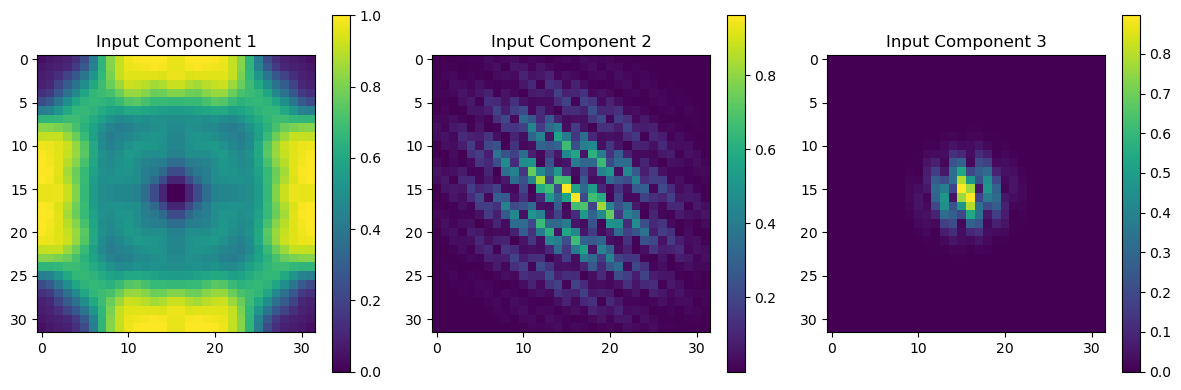

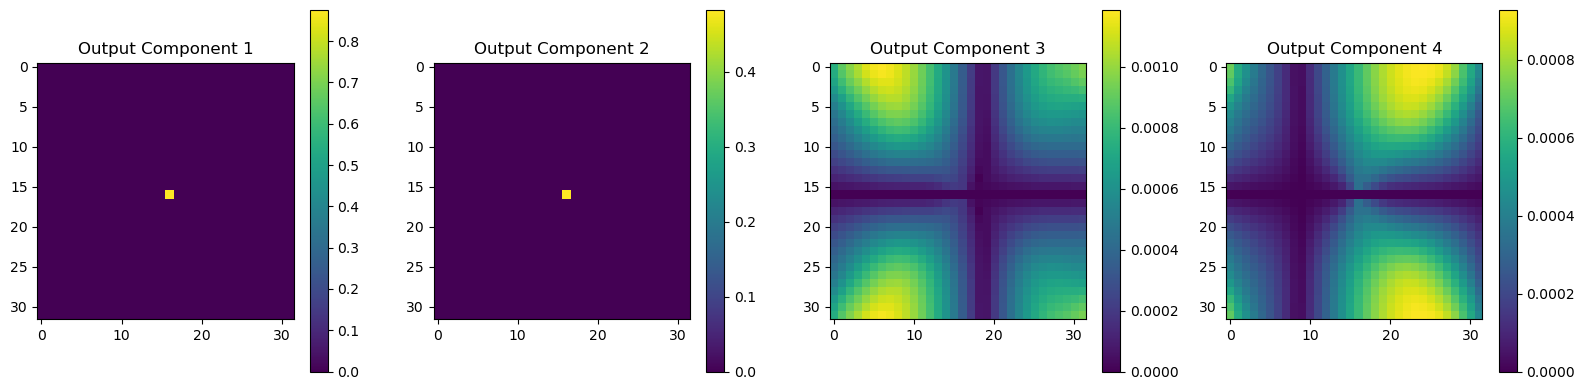

In [4]:
# Get a random sample from reduced_indices
random_idx = np.random.randint(0, len(reduced_indices))
sample_indices = reduced_indices[random_idx]
print('sample_indices:', sample_indices)



# Extract components from the sample using sample_indices
geometry = geometries[sample_indices[0]]
waveform = waveforms[sample_indices[1]]
band_fft = band_ffts[sample_indices[2]] 
input_tensors = torch.stack([geometry, waveform, band_fft])
displacement = displacements[random_idx]
if isinstance(displacement, tuple):
    output_tensors = torch.stack(displacement)

# Print type and shape of each component
print("Geometry type:", type(geometry))
print("Geometry shape:", geometry.shape)
print("Waveform type:", type(waveform))
print("Waveform shape:", waveform.shape)
print("Band FFT type:", type(band_fft))
print("Band FFT shape:", band_fft.shape)
print("Displacement type:", type(output_tensors))
print("Displacement shape:", output_tensors.shape)
print(f"Visualizing random sample {random_idx}")
visualize_sample(input_tensors, output_tensors, None)

## Model evaluation

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.5.1


In [7]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels, out_channels, hidden, num_layers):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.num_layers = num_layers

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, 
                         out_channels=self.out_channels, 
                         n_modes_height=self.modes_height, 
                         n_modes_width=self.modes_width, 
                         hidden_channels=self.hidden, 
                         n_layers=self.num_layers)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

design_res = 32
hc = 128
model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=hc, num_layers=4).to(device)
load_path = './models/final_bcdr_f16_L2_hc128_lr2e-03_wd1e-05_ss2_gamma9e-01_e20.pth'
load_existing_model = True
if load_existing_model and os.path.isfile(load_path):
    try:
        # Load the state dict
        state_dict = torch.load(load_path, map_location=device)
        
        # Remove any metadata keys
        if isinstance(state_dict, dict):
            # Remove any keys that start with underscore (metadata)
            state_dict = {k: v for k, v in state_dict.items() if not k.startswith('_')}
        
        # Load the cleaned state dict
        model.load_state_dict(state_dict)
        print(f"Loaded model weights from {load_path}")
        
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Model will start with random weights")

model.eval()

C:\Users\hz283\AppData\Local\Temp\ipykernel_44380\3557470270.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


Loaded model weights from ./models/final_bcdr_f16_L2_hc128_lr2e-03_wd1e-05_ss2_gamma9e-01_e20.pth


FourierNeuralOperator(
  (fno): FNO2d(
    (positional_embedding): GridEmbeddingND()
    (fno_blocks): FNOBlocks(
      (convs): ModuleList(
        (0-3): 4 x SpectralConv(
          (weight): DenseTensor(shape=torch.Size([128, 128, 32, 17]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0-3): 4 x Flattened1dConv(
          (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (channel_mlp): ModuleList(
        (0-3): 4 x ChannelMLP(
          (fcs): ModuleList(
            (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
            (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
          )
        )
      )
      (channel_mlp_skips): ModuleList(
        (0-3): 4 x SoftGating()
      )
    )
    (lifting): ChannelMLP(
      (fcs): ModuleList(
        (0): Conv1d(5, 256, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      )
    )
    (projection): ChannelMLP(
      (fcs):

Sample 0: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.7153
Output max: 0.0330, min: -0.0163
Target max: 0.0314, min: -0.0154
Target scale (max - min): 0.0469
Average absolute error per pixel (output vs target): 0.000824


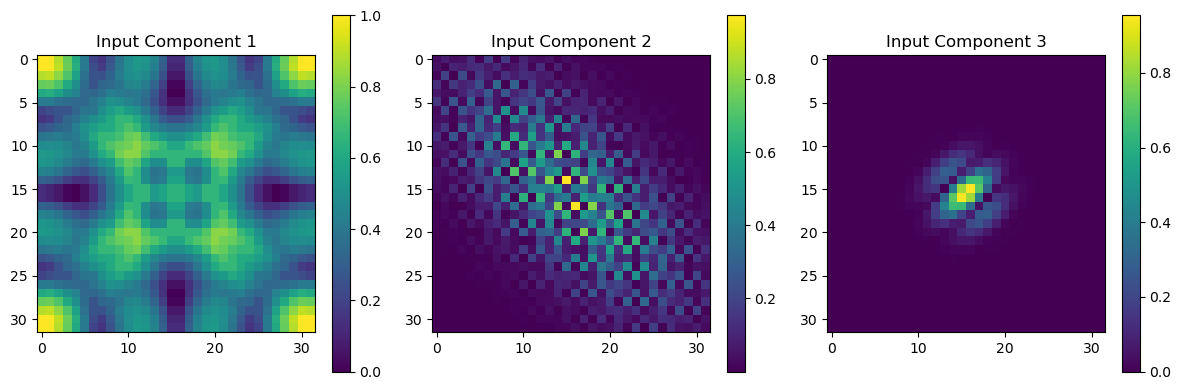

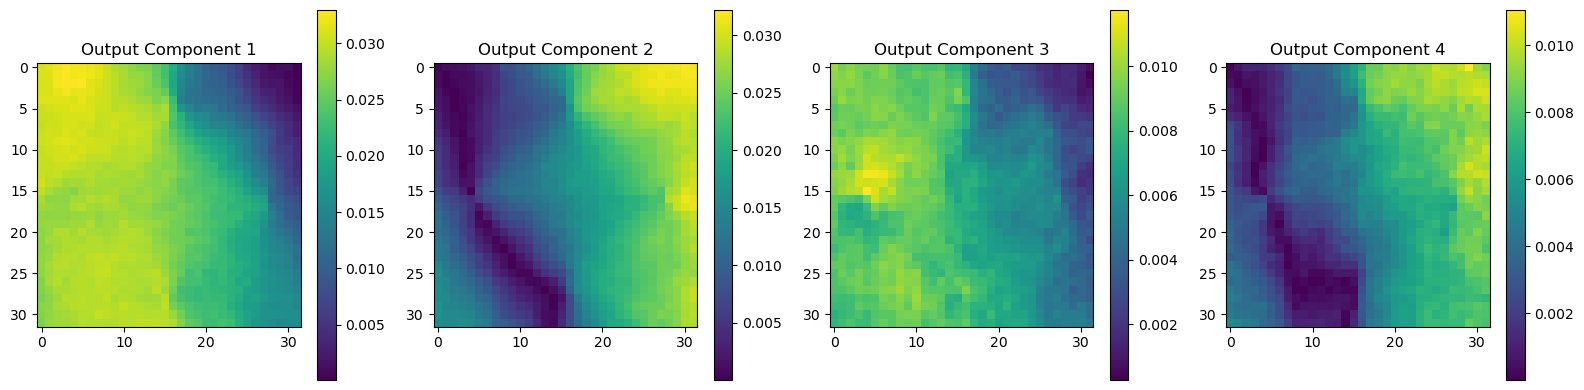

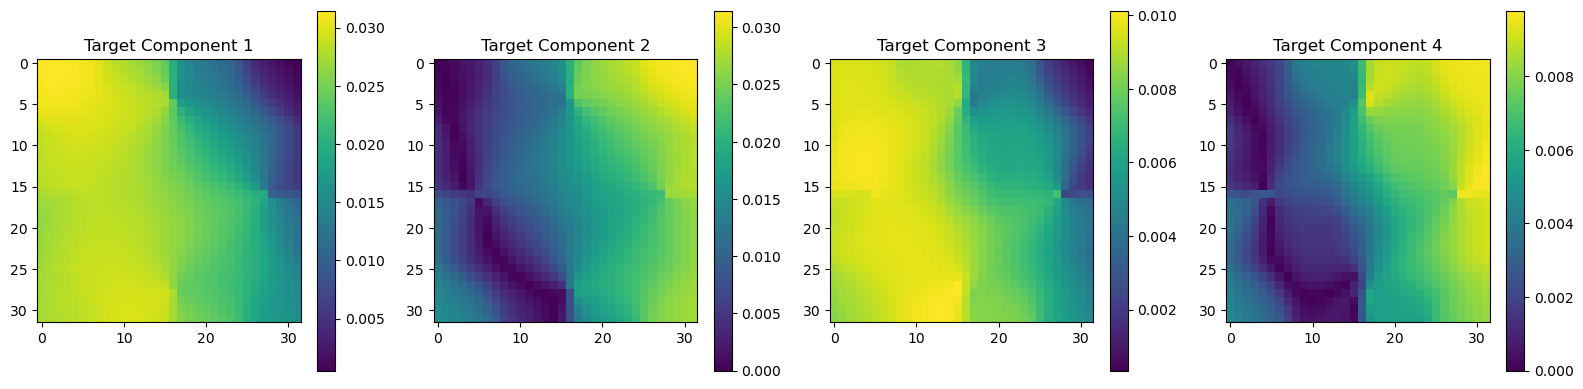

Sample 1: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.8066
Output max: 0.0016, min: -0.7310
Target max: 0.0010, min: -0.7505
Target scale (max - min): 0.7515
Average absolute error per pixel (output vs target): 0.000457


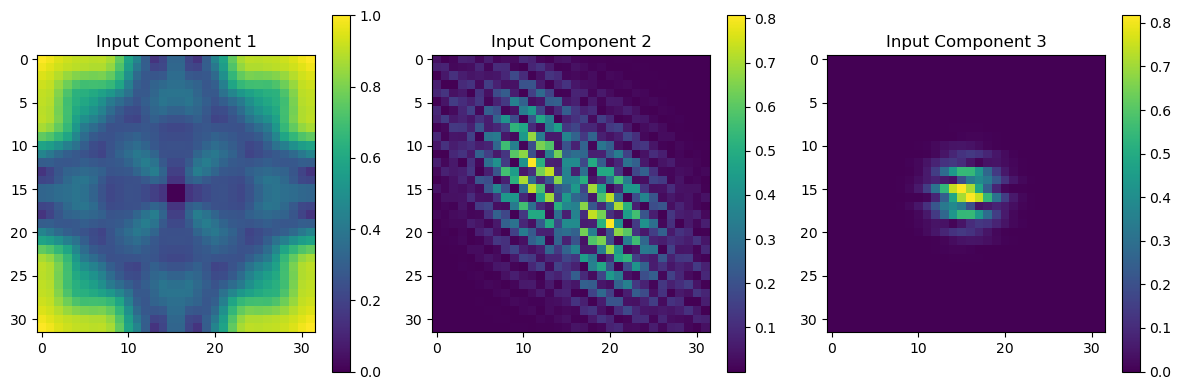

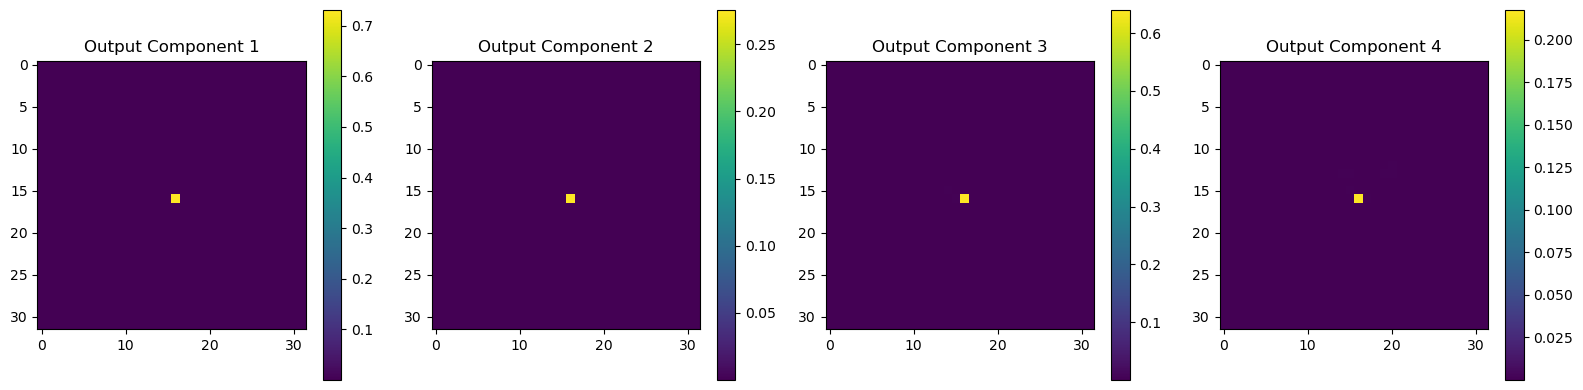

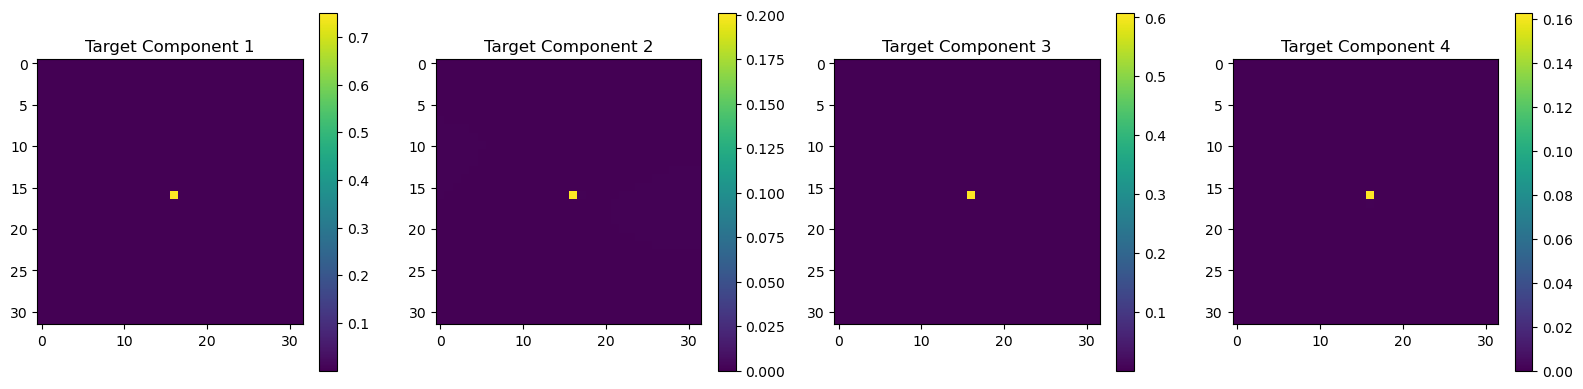

Sample 2: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.7646
Output max: 0.1947, min: -0.1546
Target max: 0.2001, min: -0.1591
Target scale (max - min): 0.3591
Average absolute error per pixel (output vs target): 0.000372


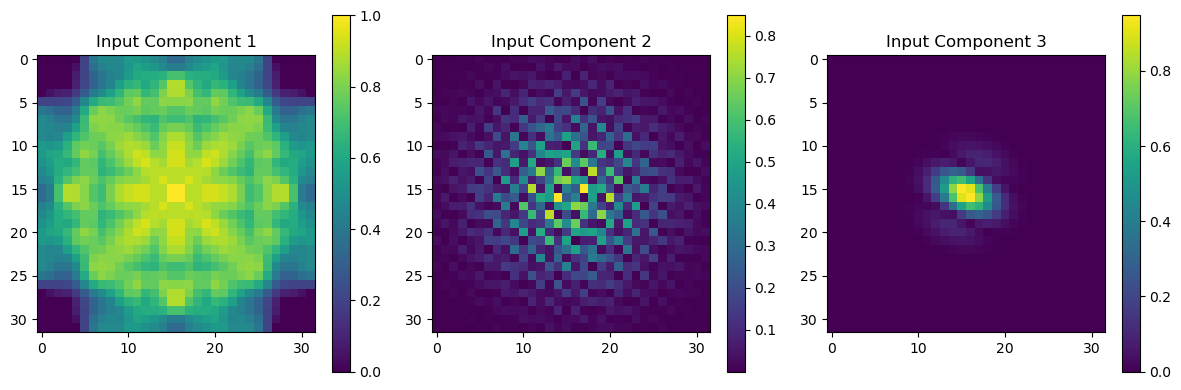

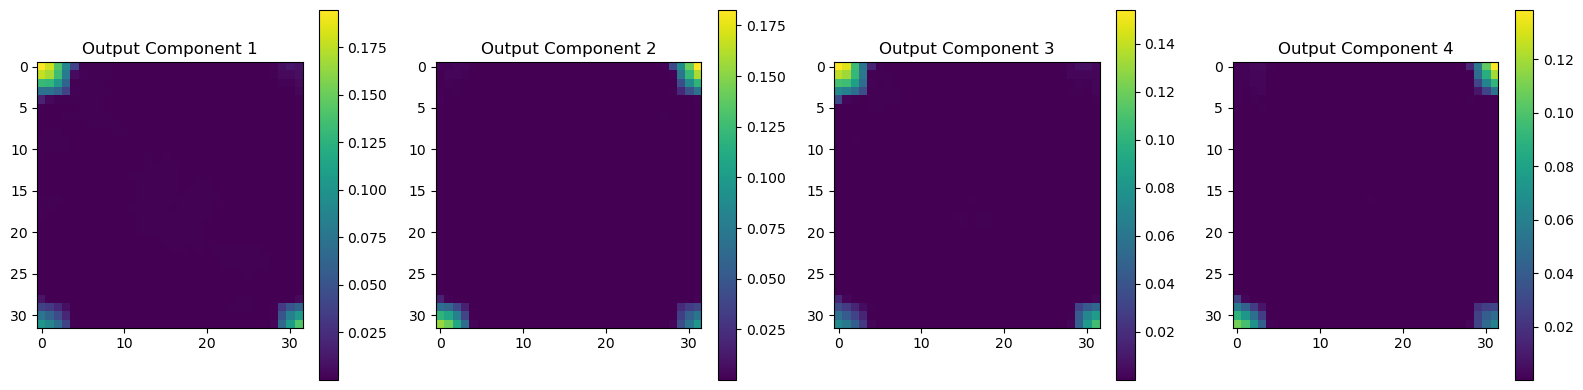

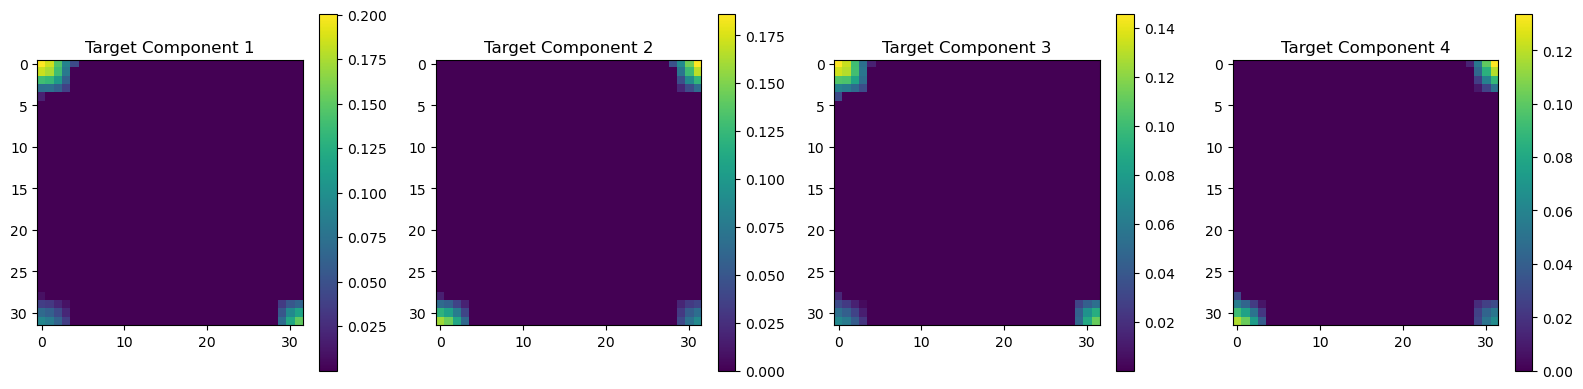

Sample 3: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 0.9541, min: -0.6621
Output max: 0.0253, min: -0.0292
Target max: 0.0253, min: -0.0253
Target scale (max - min): 0.0506
Average absolute error per pixel (output vs target): 0.002172


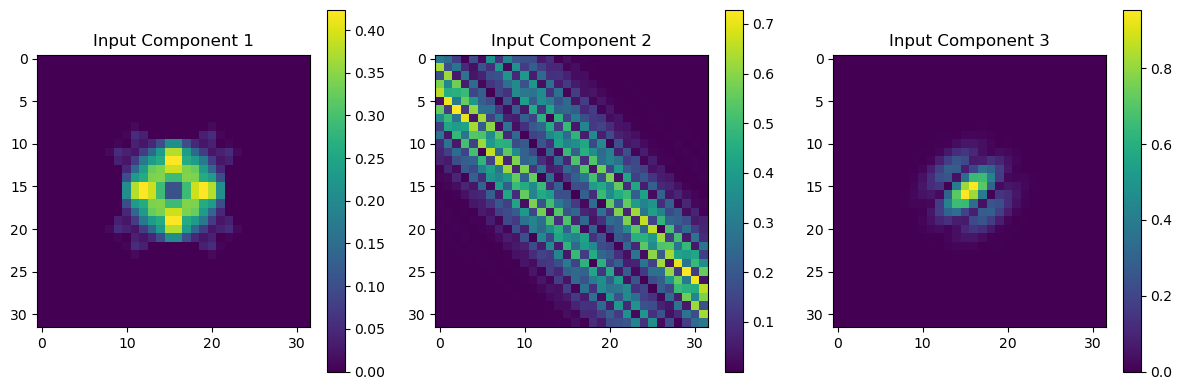

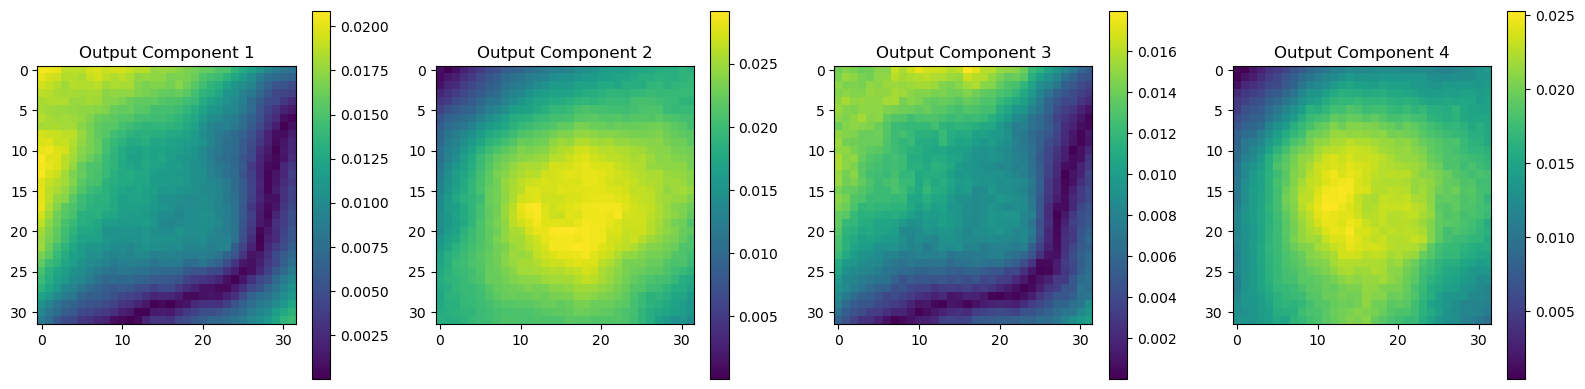

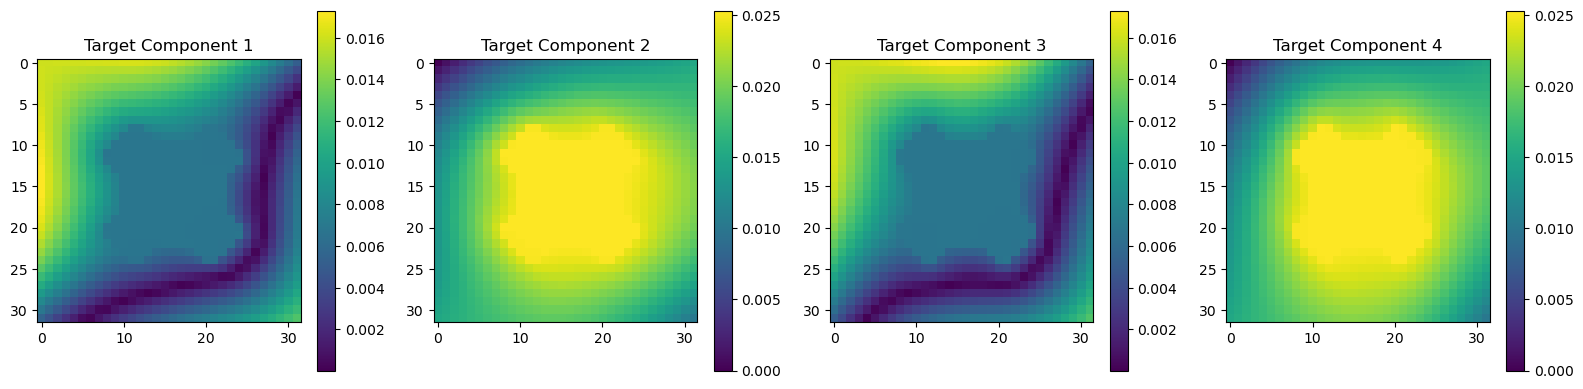

Sample 4: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.8740
Output max: 0.3940, min: -0.5508
Target max: 0.4978, min: -0.4978
Target scale (max - min): 0.9956
Average absolute error per pixel (output vs target): 0.000673


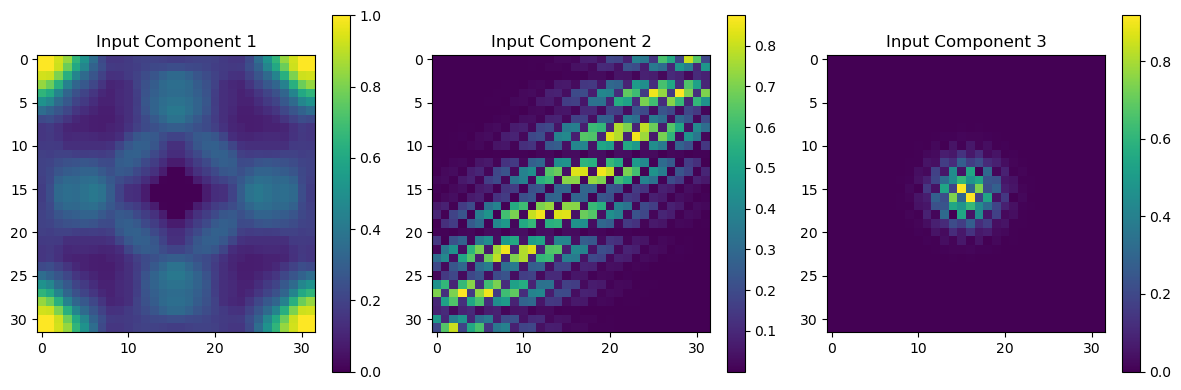

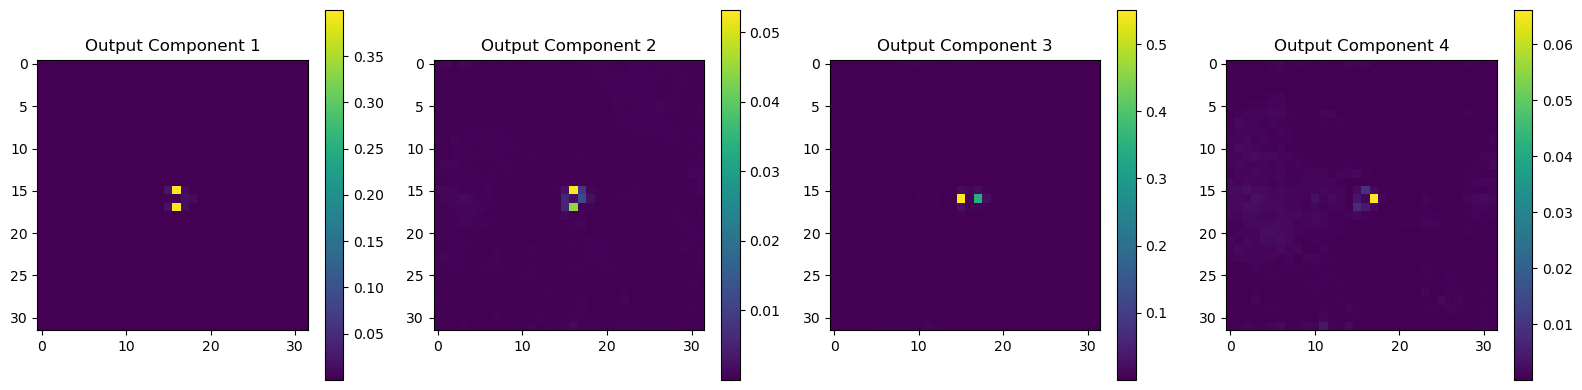

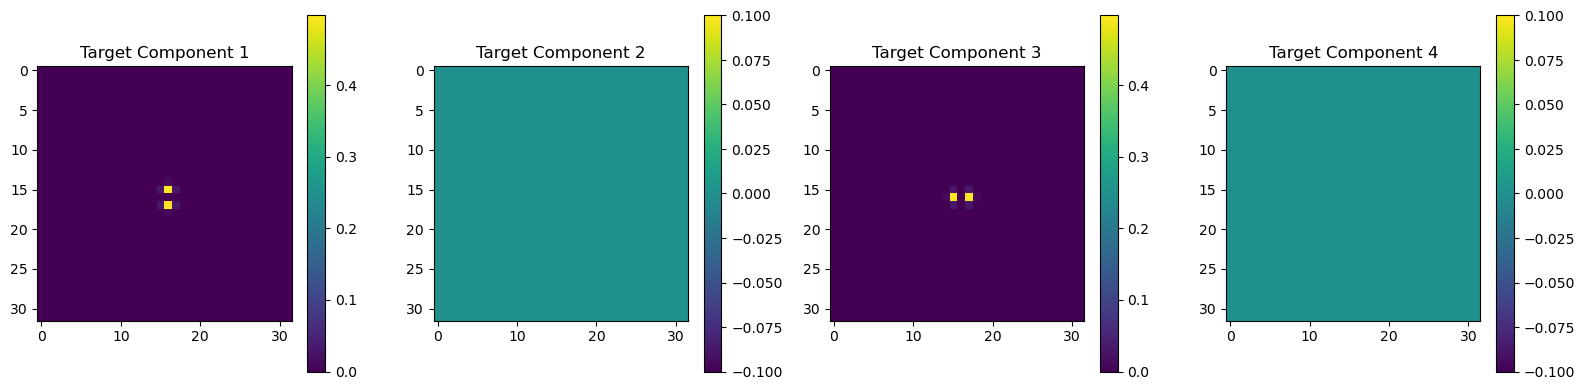

Sample 5: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.8345
Output max: 0.0055, min: -0.3457
Target max: 0.0026, min: -0.3582
Target scale (max - min): 0.3607
Average absolute error per pixel (output vs target): 0.001165


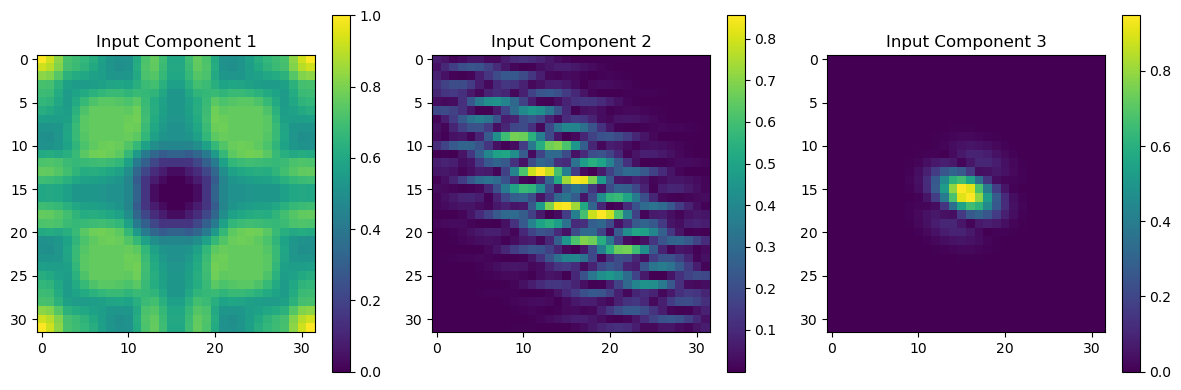

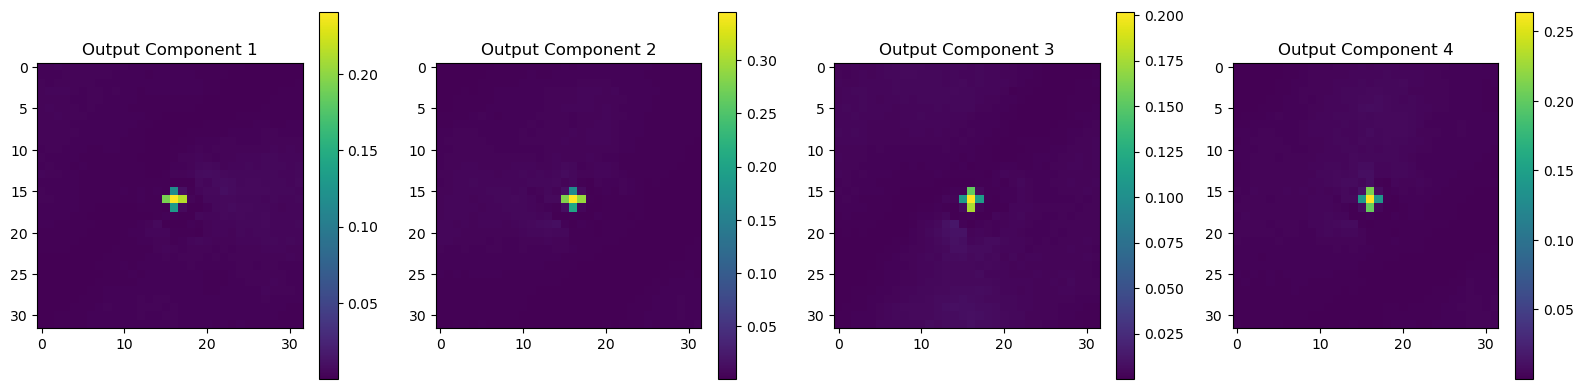

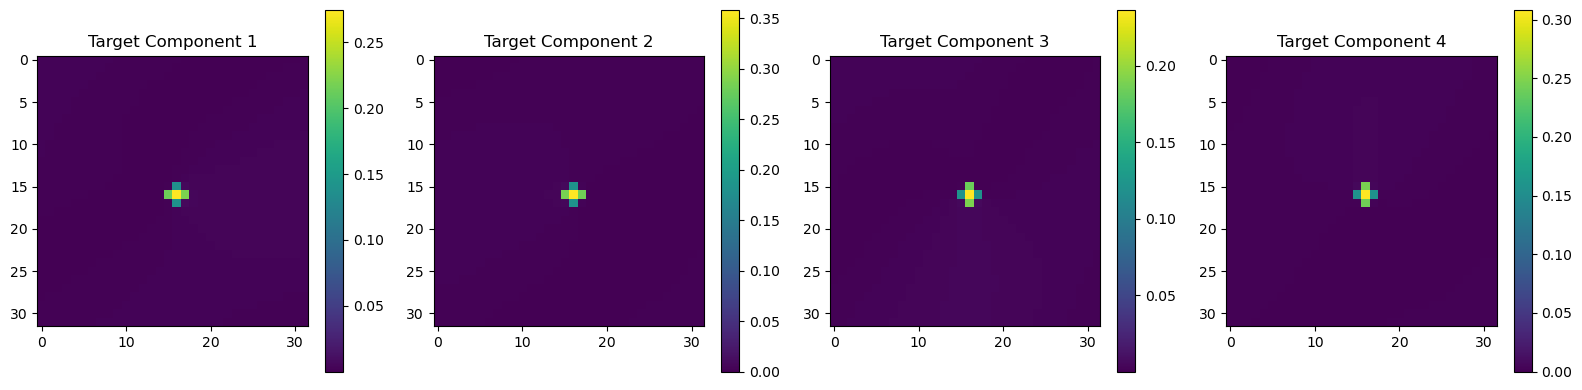

Sample 6: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.9541
Output max: 0.2695, min: -0.2340
Target max: 0.2676, min: -0.2676
Target scale (max - min): 0.5352
Average absolute error per pixel (output vs target): 0.000758


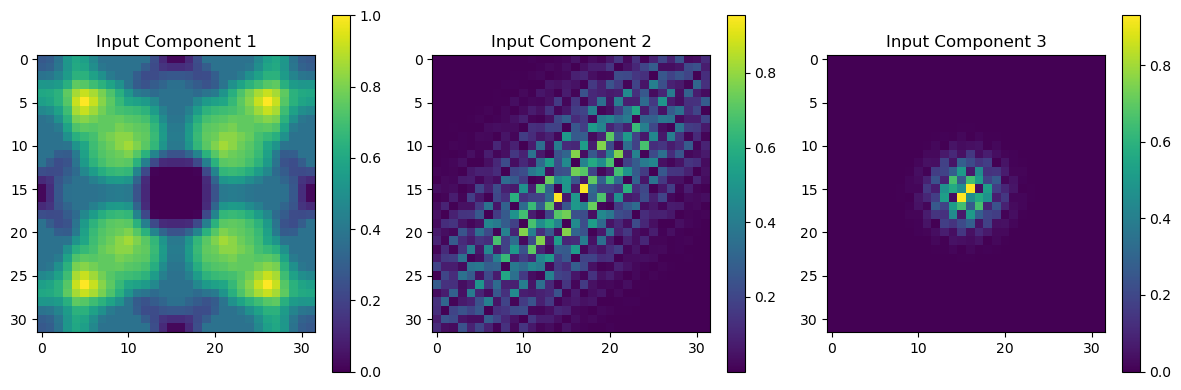

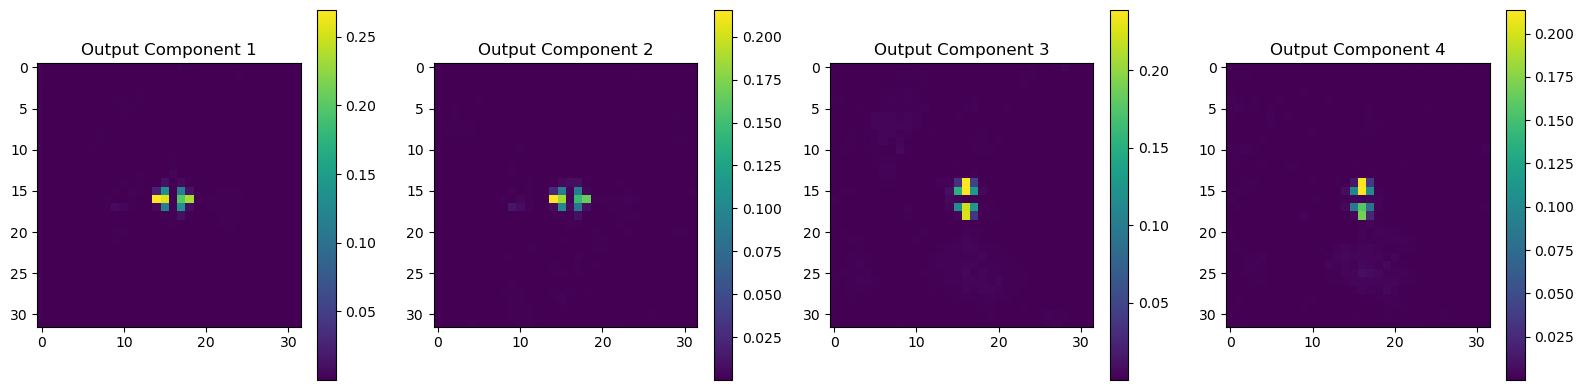

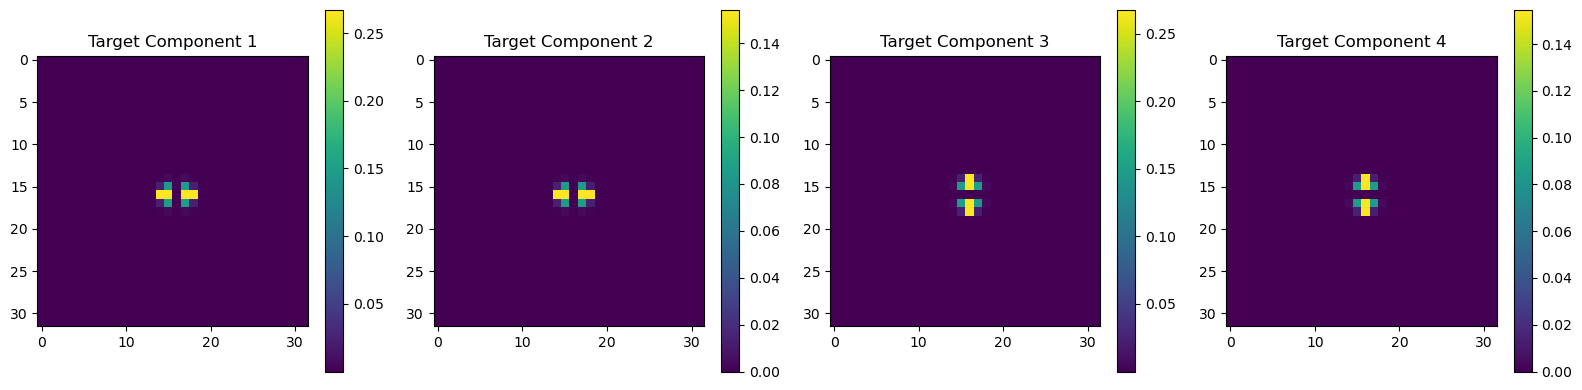

Sample 7: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.7607
Output max: 0.4096, min: -0.1990
Target max: 0.5996, min: -0.2483
Target scale (max - min): 0.8479
Average absolute error per pixel (output vs target): 0.002489


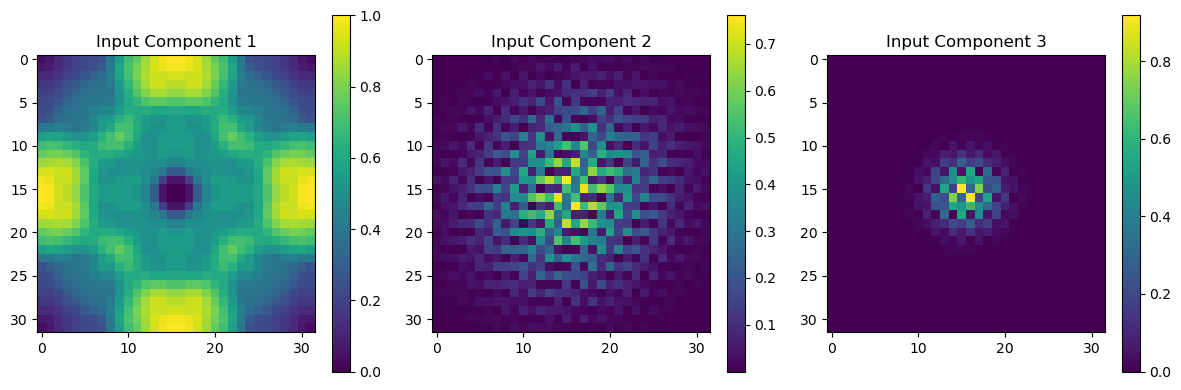

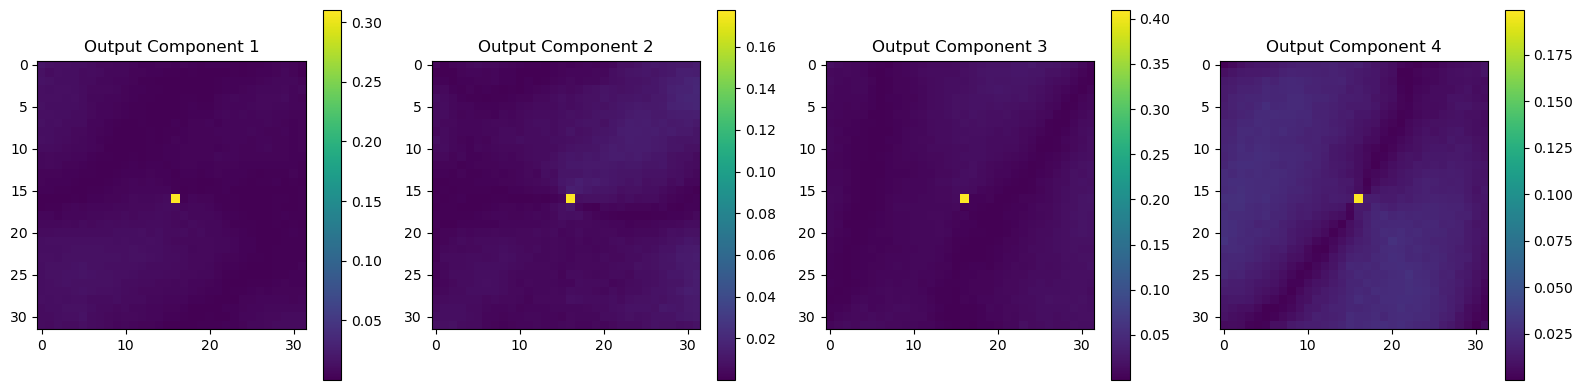

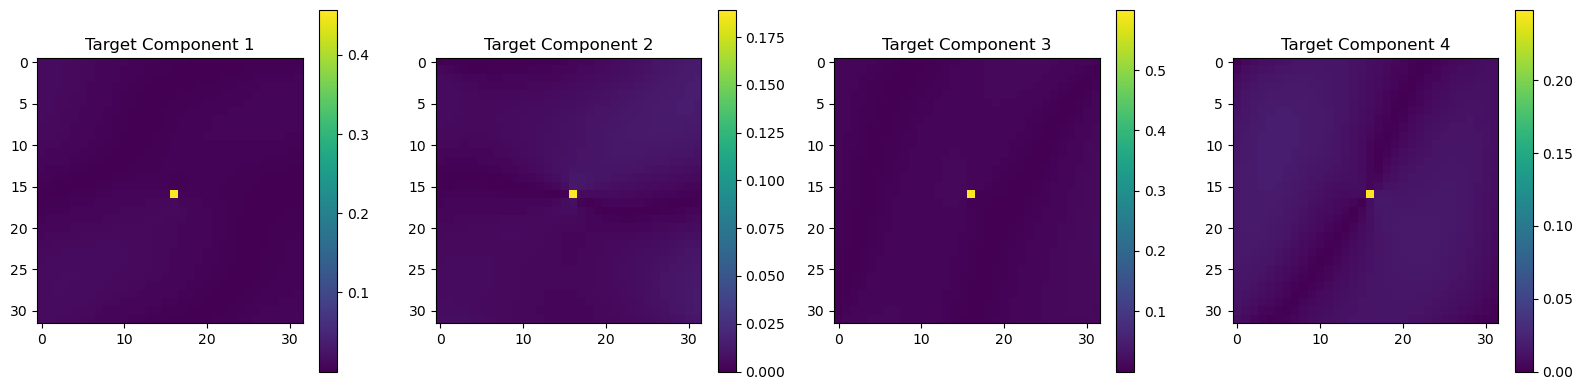

Sample 8: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.6577
Output max: 0.1315, min: -0.9526
Target max: 0.1442, min: -0.9805
Target scale (max - min): 1.1246
Average absolute error per pixel (output vs target): 0.000333


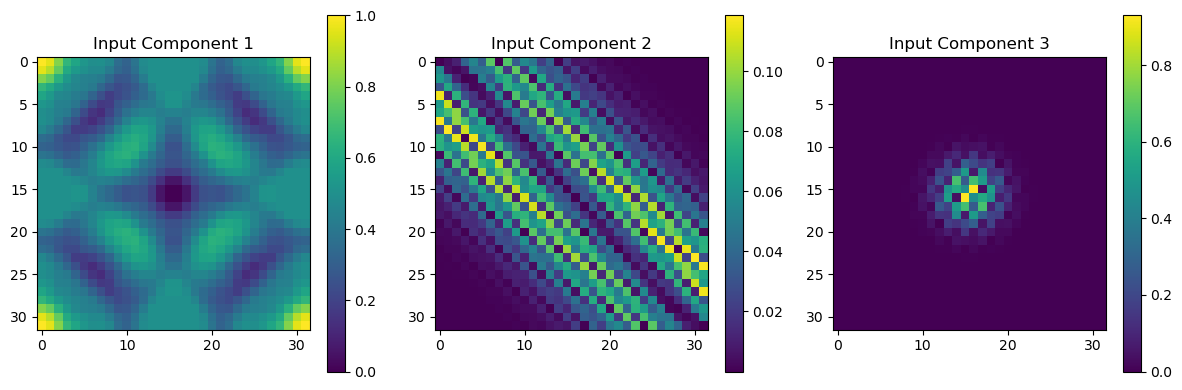

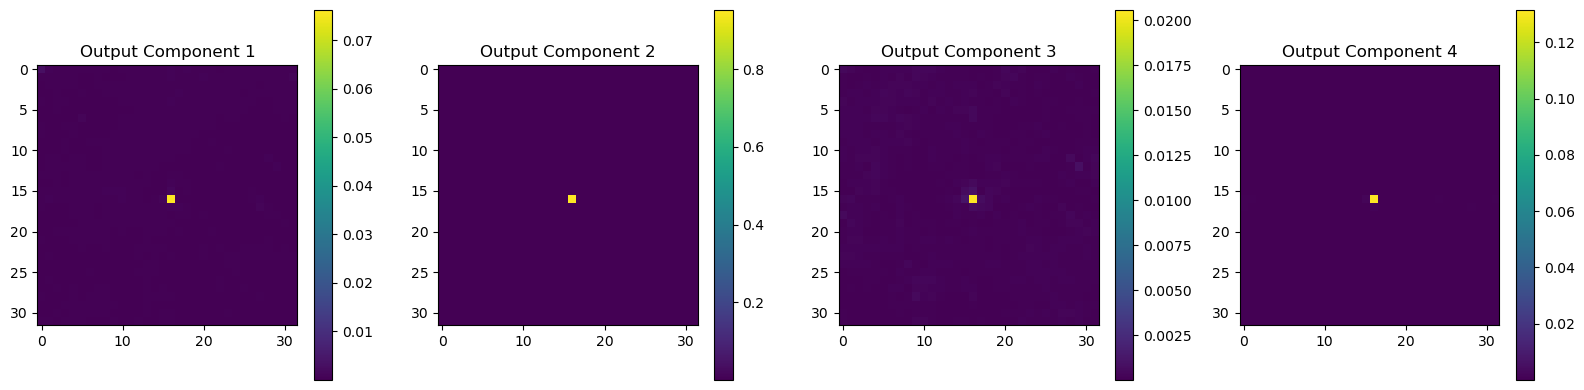

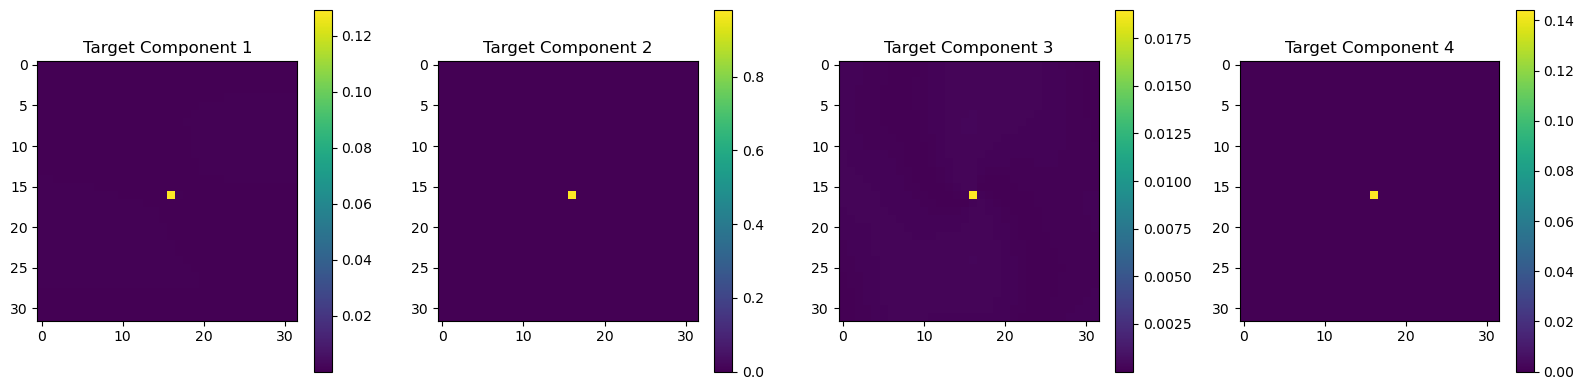

Sample 9: Input torch.Size([3, 32, 32]) torch.float16, Target torch.Size([4, 32, 32]) torch.float32
Input max: 1.0000, min: -0.8950
Output max: 0.5549, min: -0.4552
Target max: 0.6011, min: -0.4519
Target scale (max - min): 1.0530
Average absolute error per pixel (output vs target): 0.002408


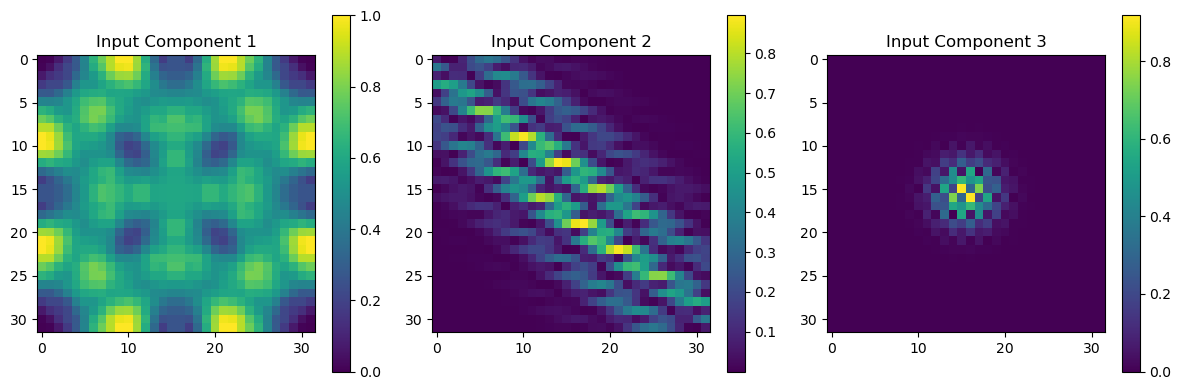

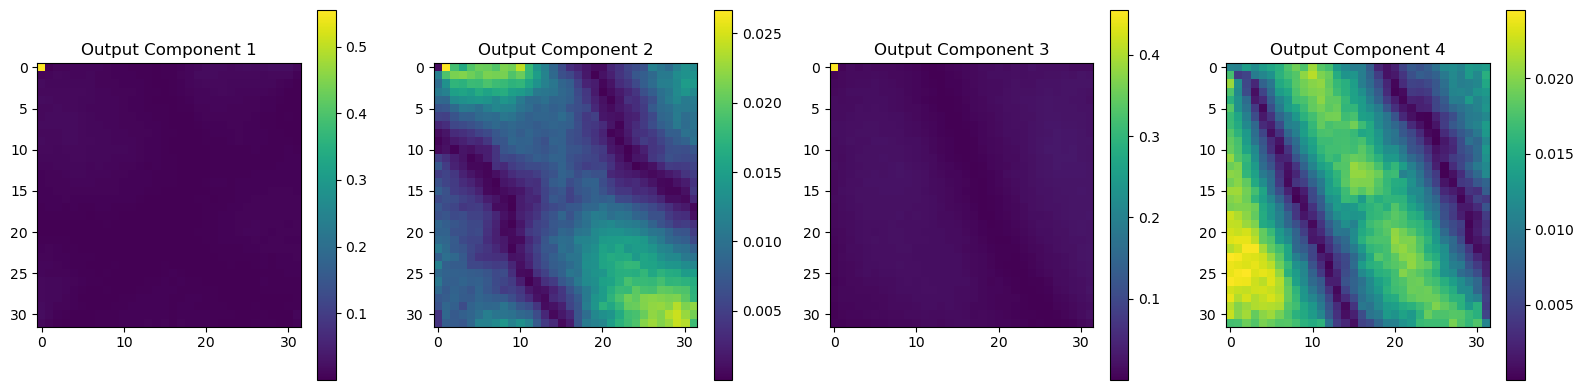

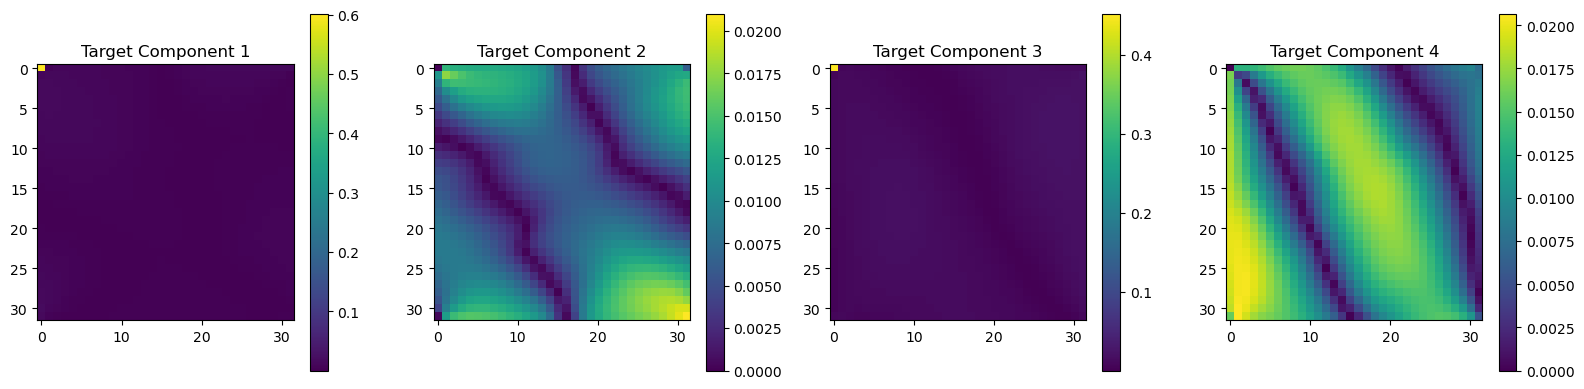

In [9]:
# Get a few random samples directly (no DataLoader needed)
num_samples = 10  # or however many you want
random_indices = torch.randperm(len(reduced_indices))[:num_samples]

# Preallocate lists for time efficiency
all_inputs = [None] * num_samples
all_predictions = [None] * num_samples
all_targets = [None] * num_samples

# Process each sample
for i, sample_idx in enumerate(random_indices):
    # Get the mapping indices
    geometry_idx, waveform_idx, band_idx = reduced_indices[sample_idx]
    
    # Fetch the actual data
    geometry = geometries[geometry_idx]
    waveform = waveforms[waveform_idx]
    band_fft = band_ffts[band_idx]
    target = torch.stack(displacements[sample_idx], dim=0)
    
    # Combine inputs
    input_tensor = torch.stack([geometry, waveform, band_fft], dim=0)  # [3, 32, 32]
    
    # Check sizes and data types
    print(f"Sample {i}: Input {input_tensor.shape} {input_tensor.dtype}, Target {target.shape} {target.dtype}")
    
    # Convert to float32 if needed to match model expectations
    if input_tensor.dtype != torch.float32:
        input_tensor = input_tensor.float()
    if target.dtype != torch.float32:
        target = target.float()
    
    # Move to device
    input_tensor = input_tensor.to(device)
    target = target.to(device)
    
    # Get prediction
    with torch.no_grad():
        prediction = model(input_tensor.unsqueeze(0)).squeeze(0)  # Add batch dim, then remove
    
    # Print max and min of input, output, and target
    print(f"Input max: {input_tensor.max():.4f}, min: {input_tensor.min():.4f}")
    print(f"Output max: {prediction.max():.4f}, min: {prediction.min():.4f}")
    print(f"Target max: {target.max():.4f}, min: {target.min():.4f}")
    print(f"Target scale (max - min): {target.max() - target.min():.4f}")
    # Compute average absolute error per pixel between output and target
    avg_abs_error = torch.mean(torch.abs(prediction - target)).item()
    print(f"Average absolute error per pixel (output vs target): {avg_abs_error:.6f}")
    
    # Visualize the sample (move tensors to CPU first)
    visualize_sample(input_tensor.cpu(), prediction.cpu(), target.cpu())
    
    # Store for plotting (keep as 3x32x32 for inputs, 4x32x32 for predictions and targets)
    all_inputs[i] = input_tensor.cpu()  # [3, 32, 32]
    all_predictions[i] = prediction.cpu()  # [4, 32, 32]
    all_targets[i] = target.cpu()  # [4, 32, 32]


Visualizing sample 0 (index 133879)


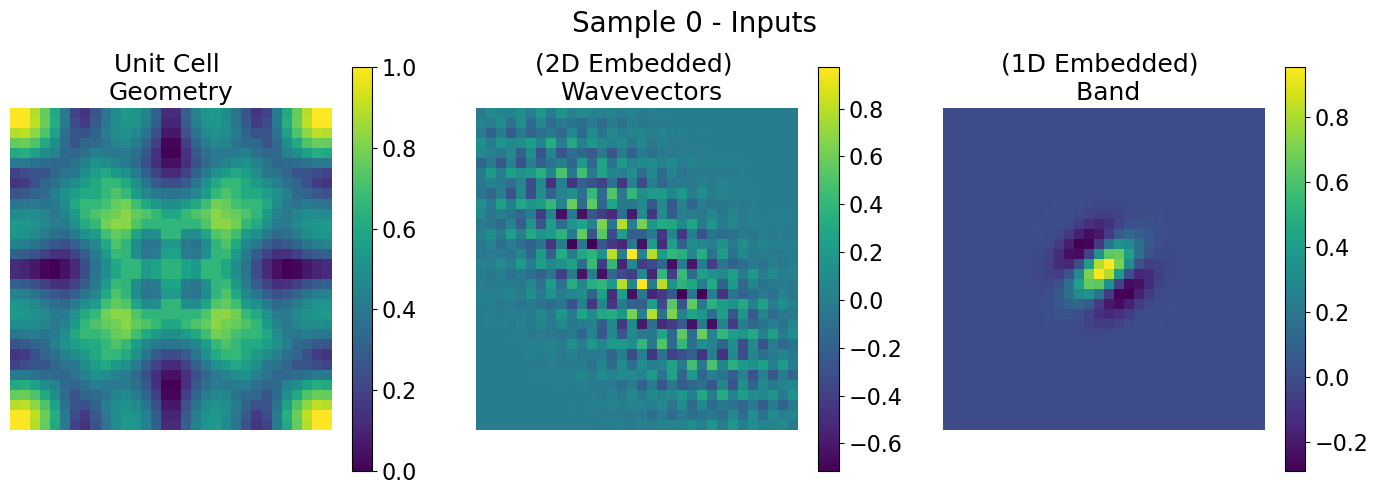

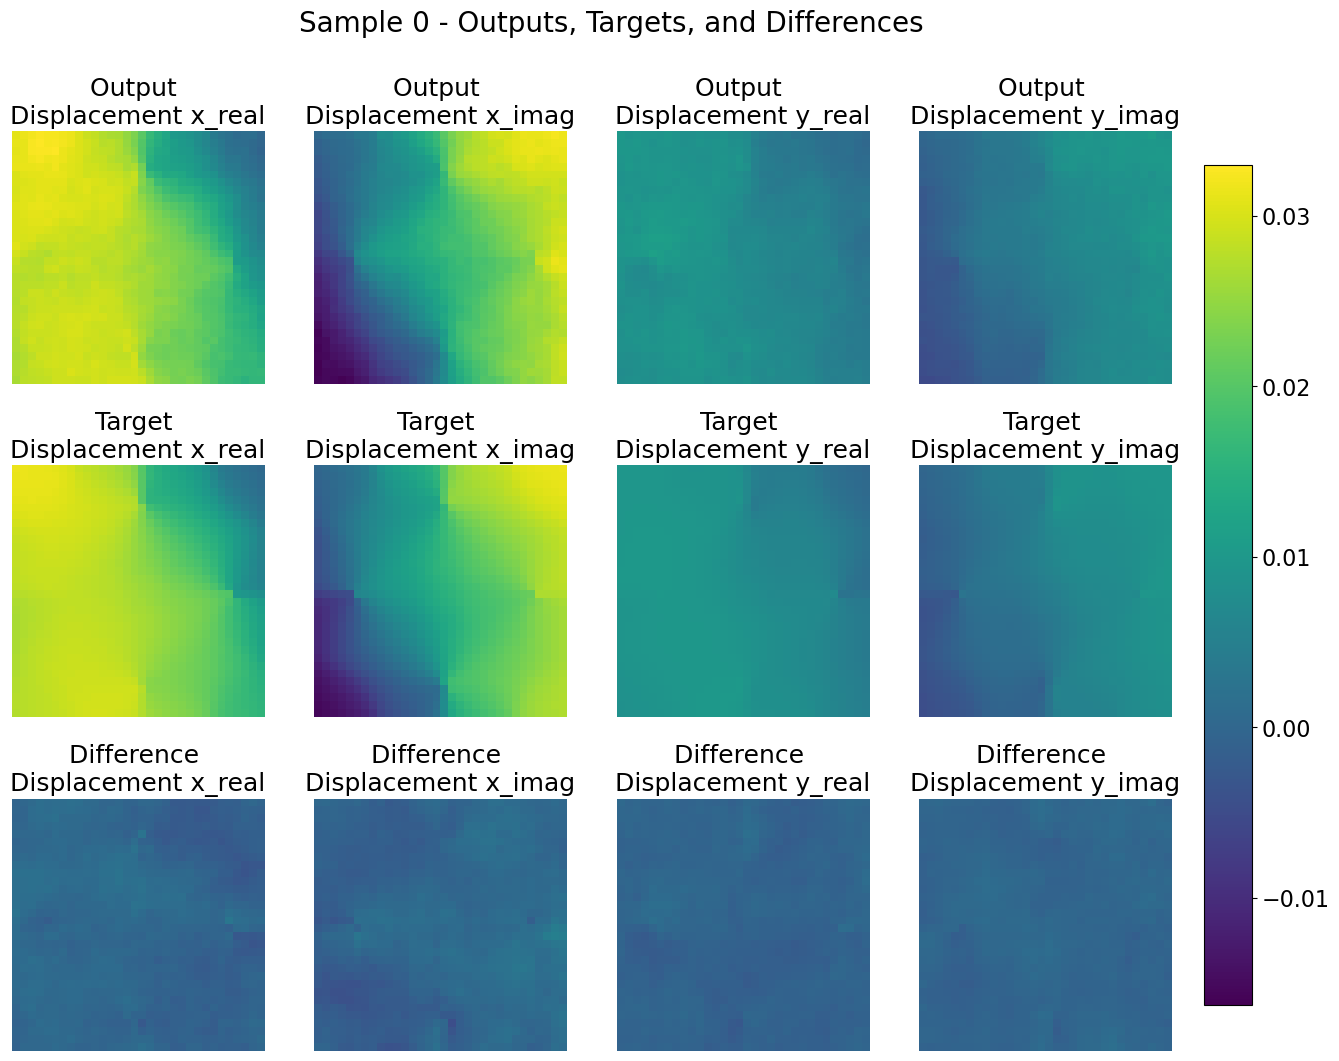

Visualizing sample 1 (index 106901)


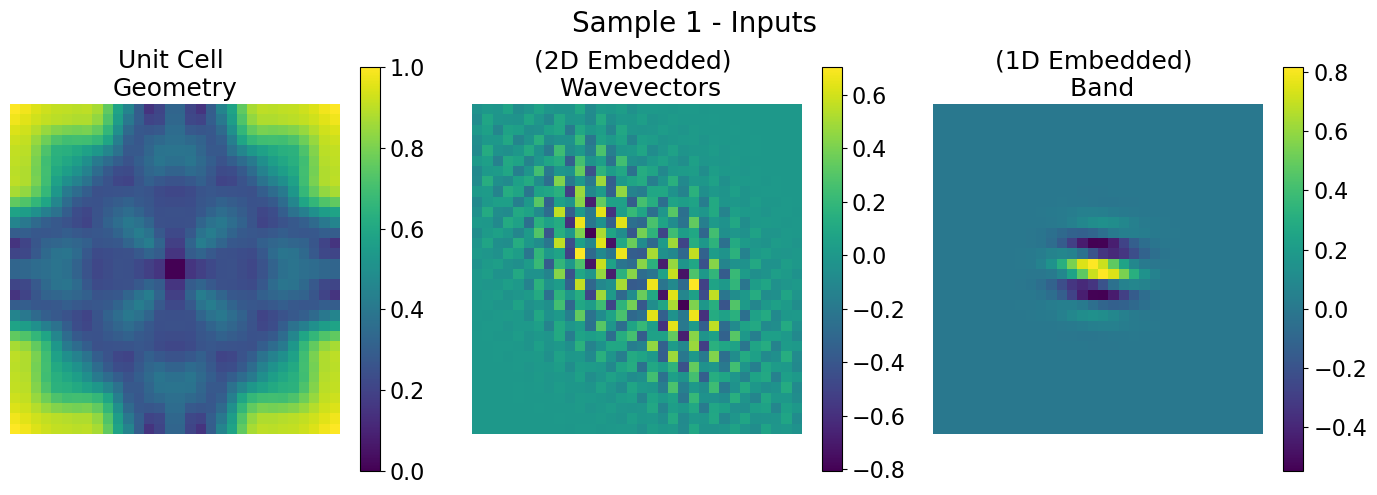

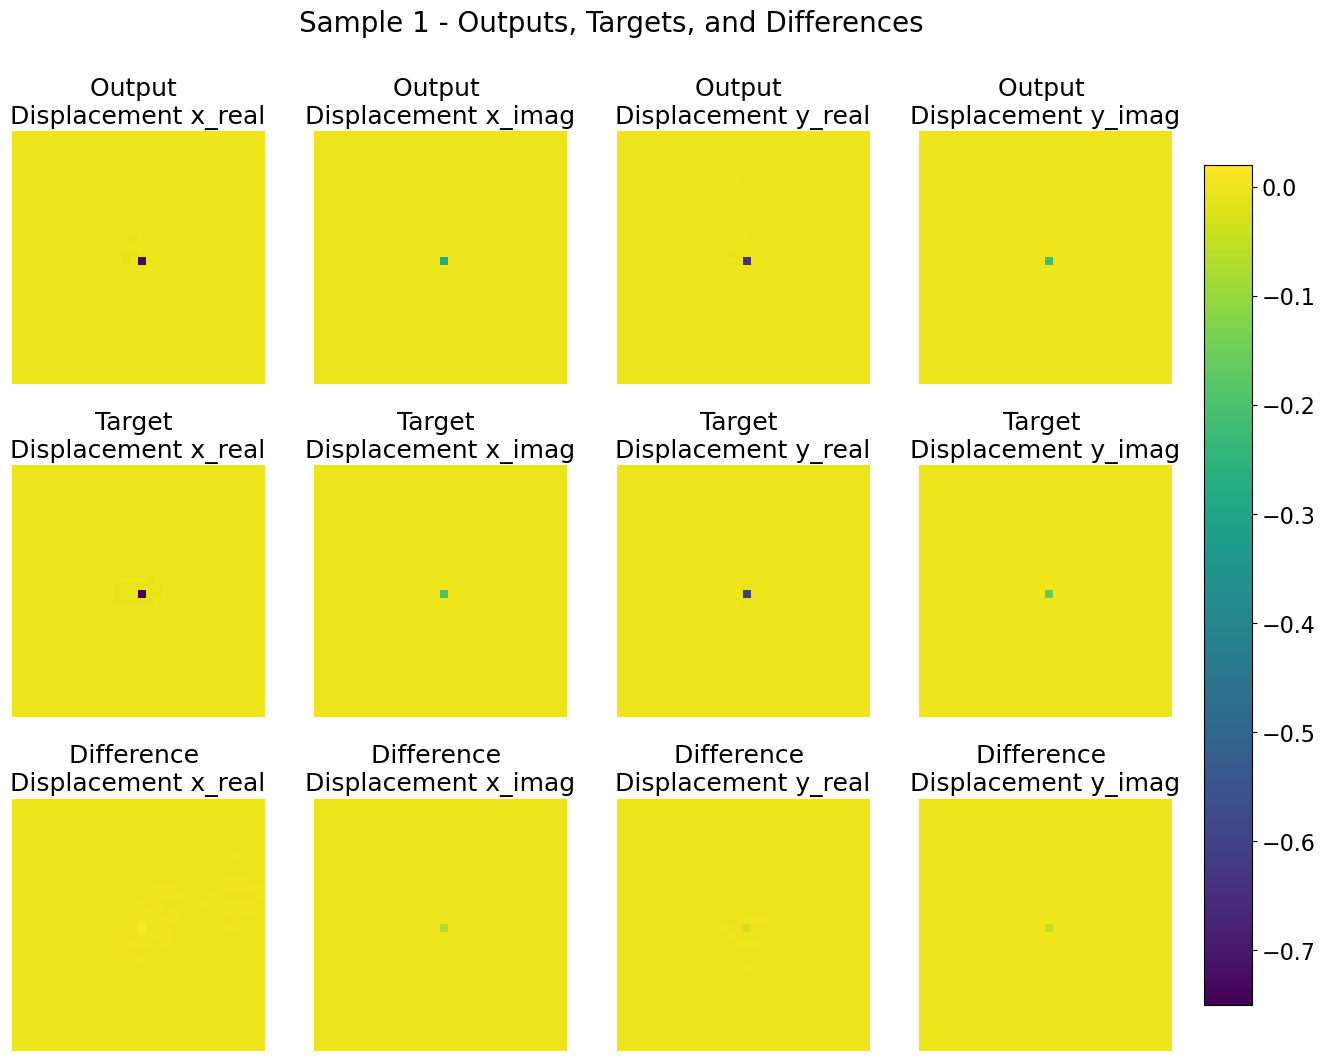

Visualizing sample 2 (index 228005)


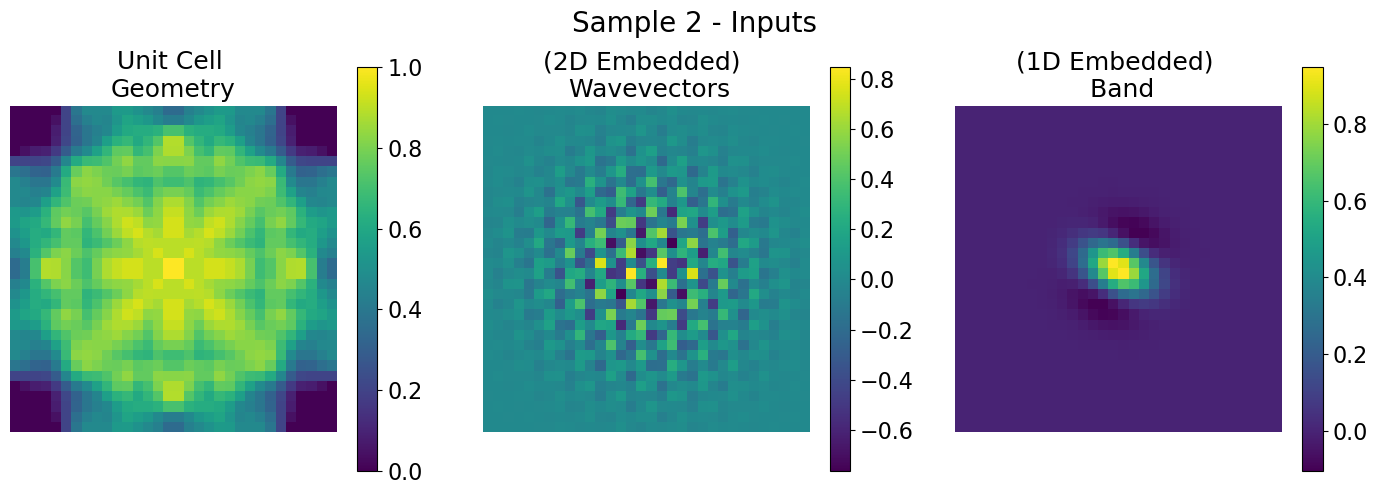

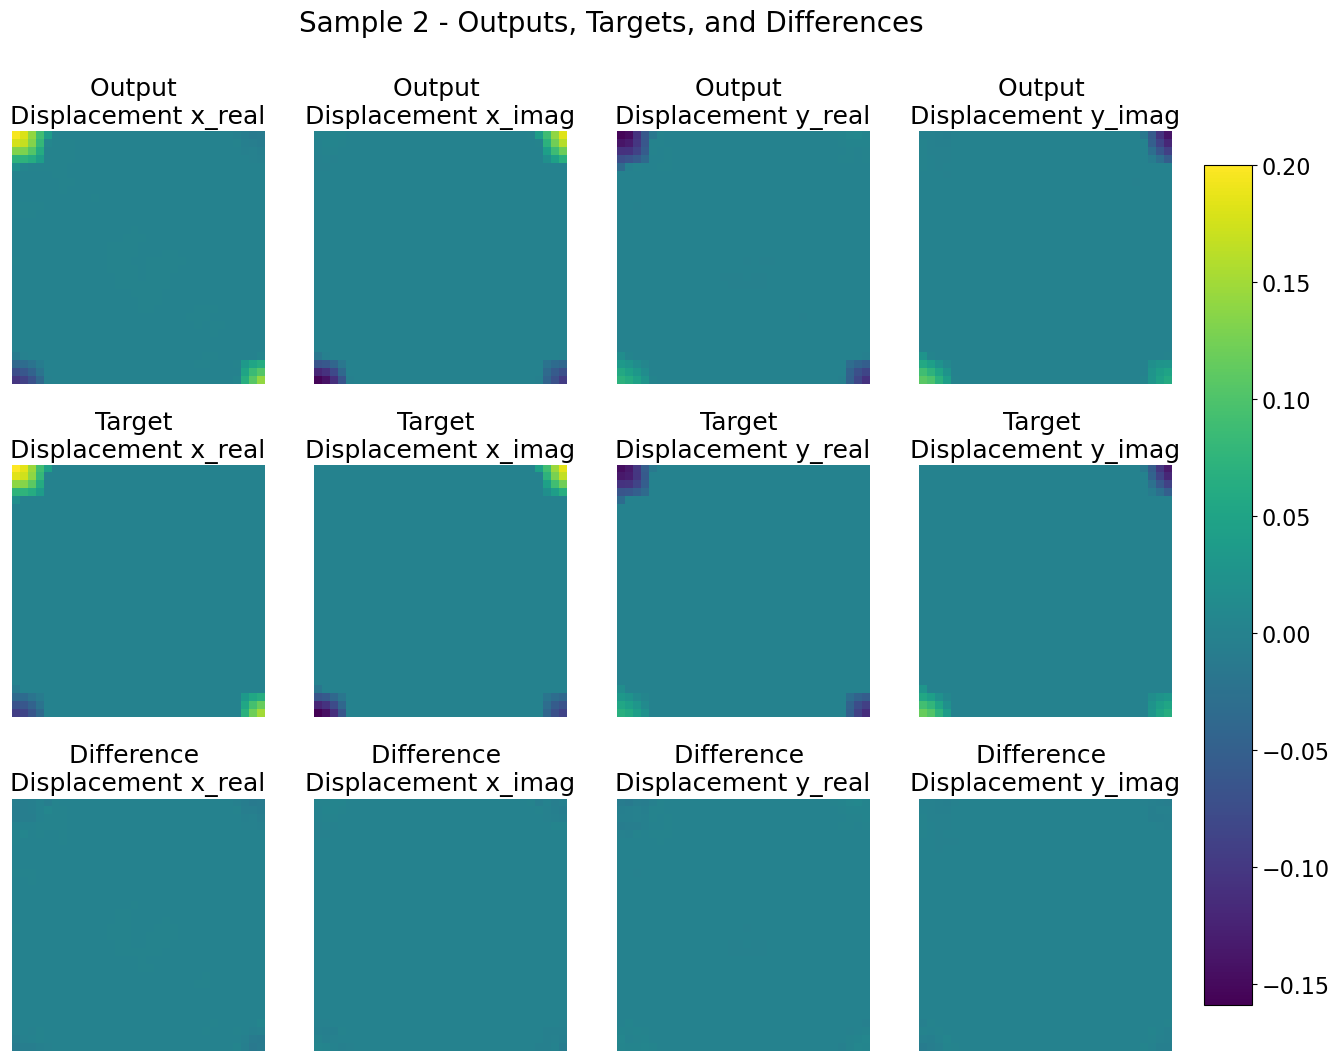

Visualizing sample 3 (index 36256)


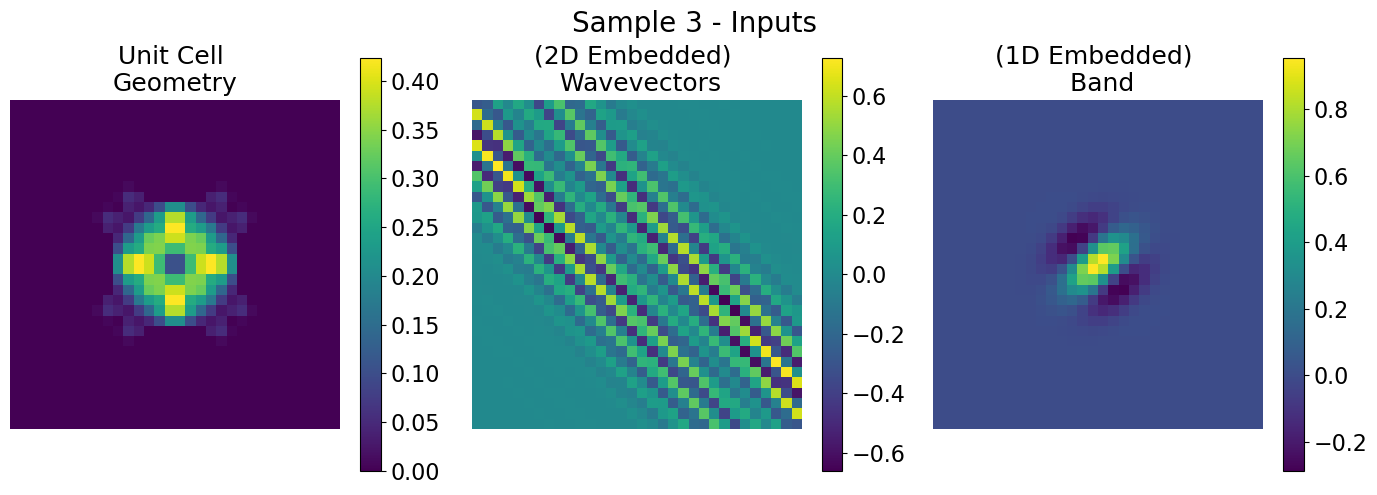

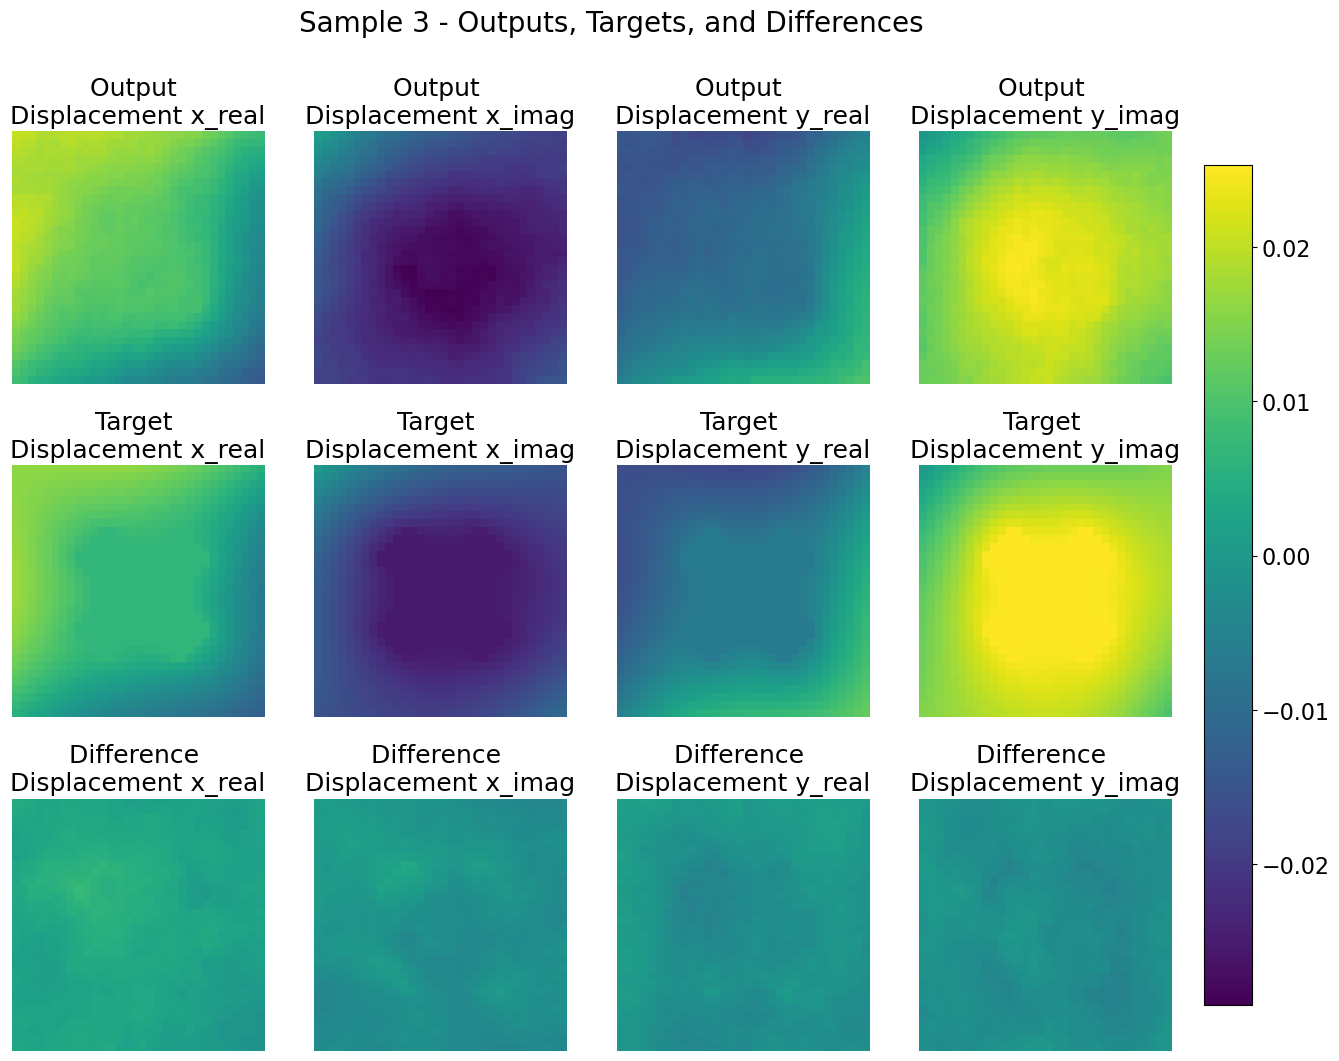

Visualizing sample 4 (index 64550)


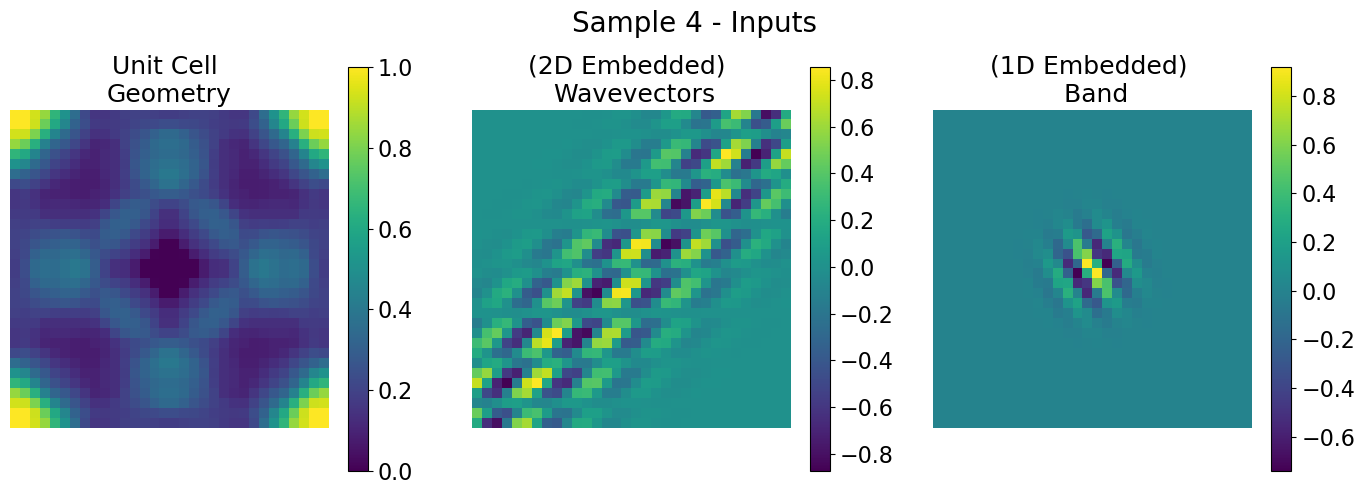

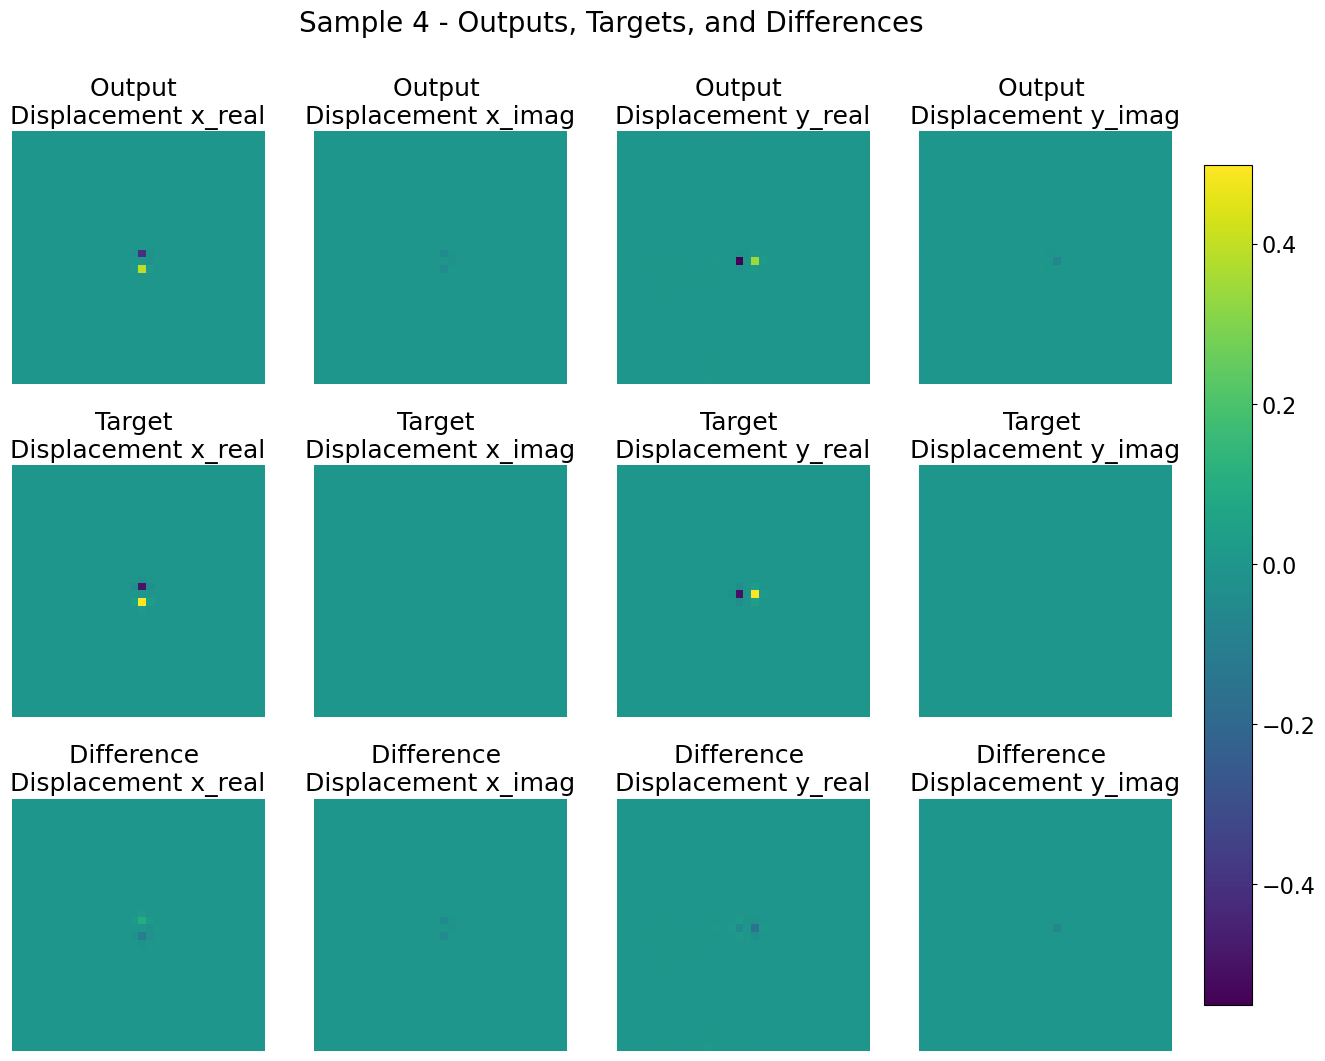

Visualizing sample 5 (index 2670)


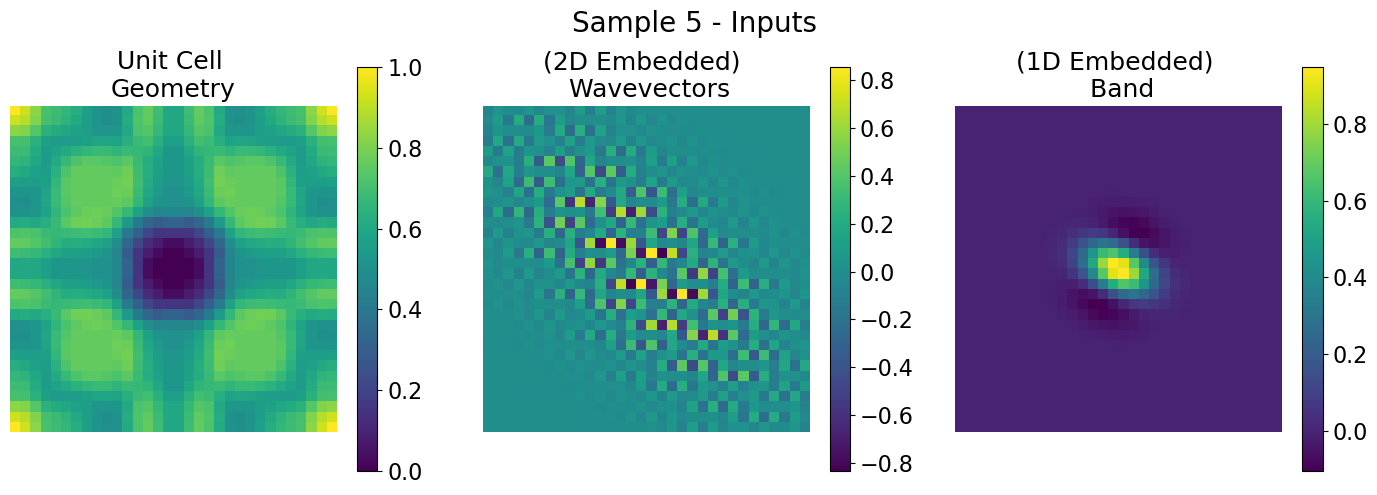

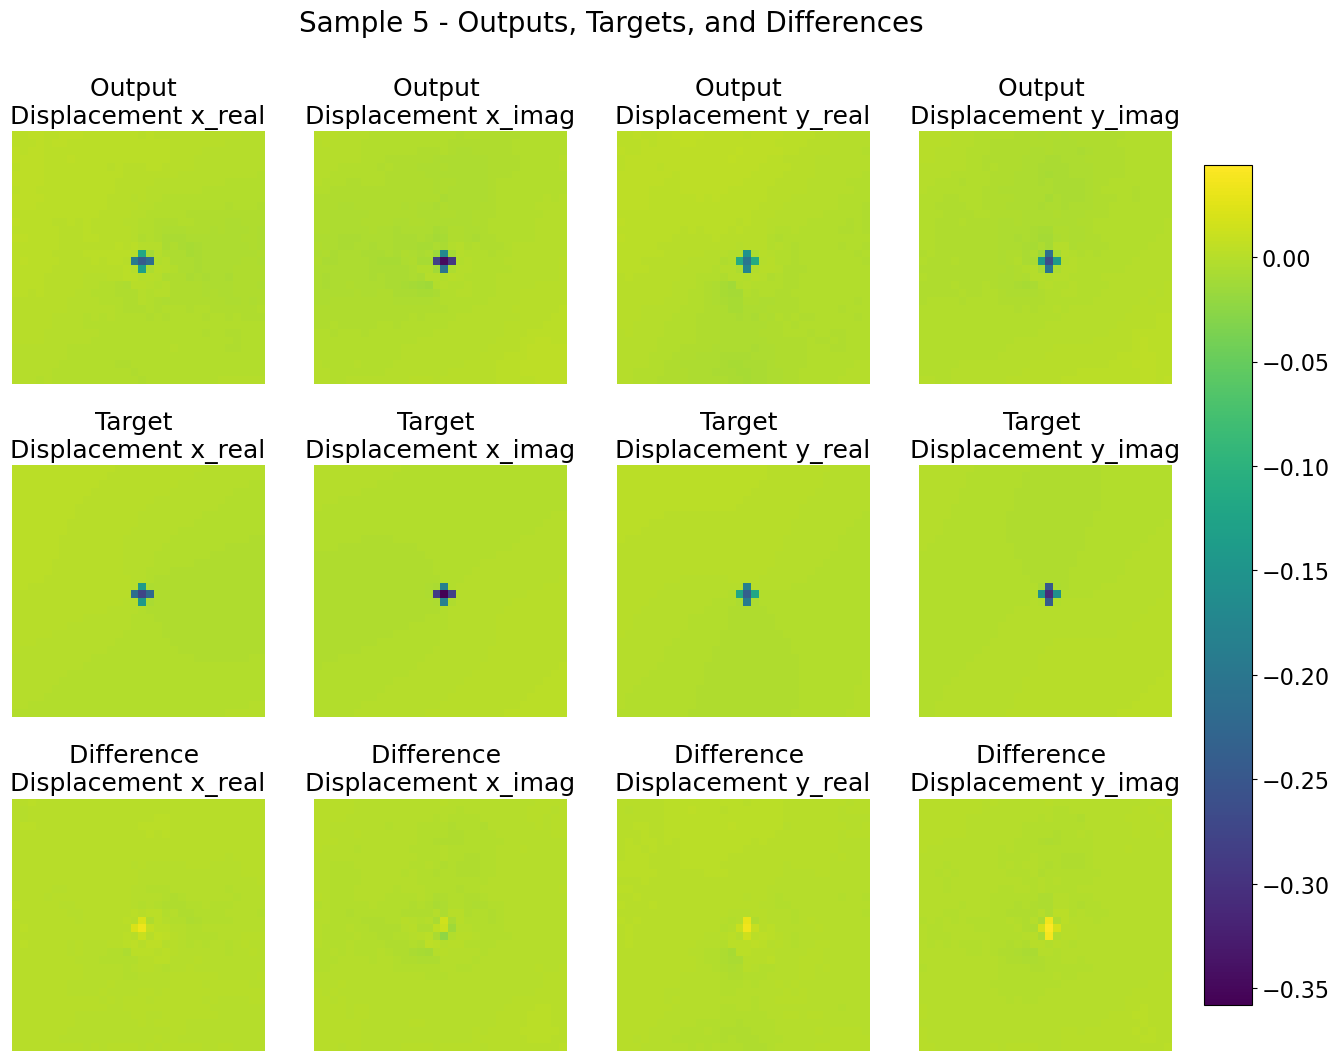

Visualizing sample 6 (index 212333)


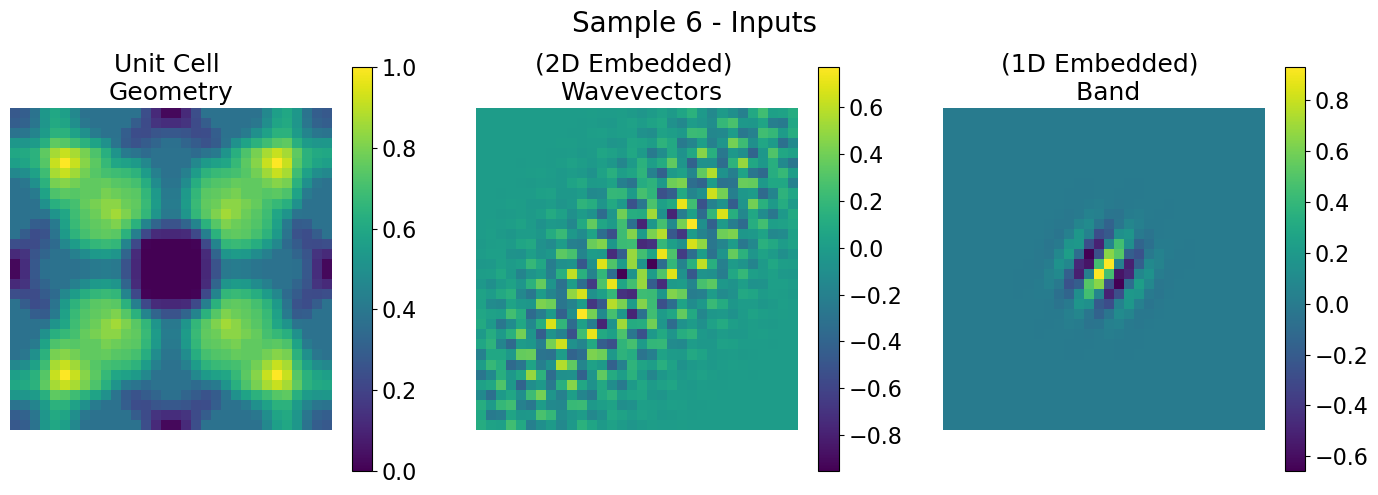

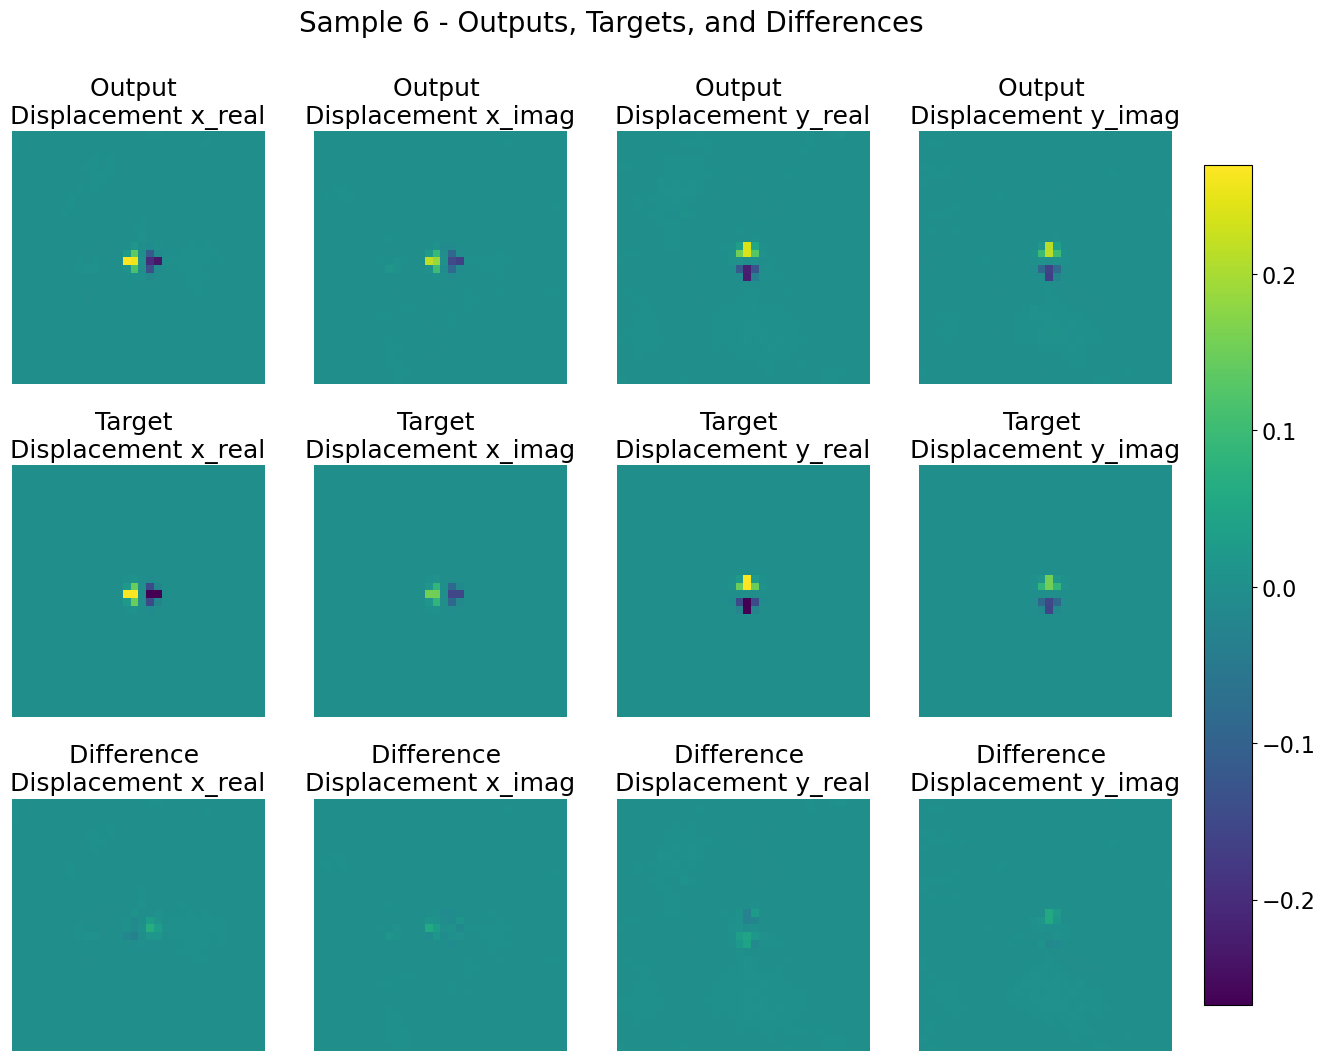

Visualizing sample 7 (index 61039)


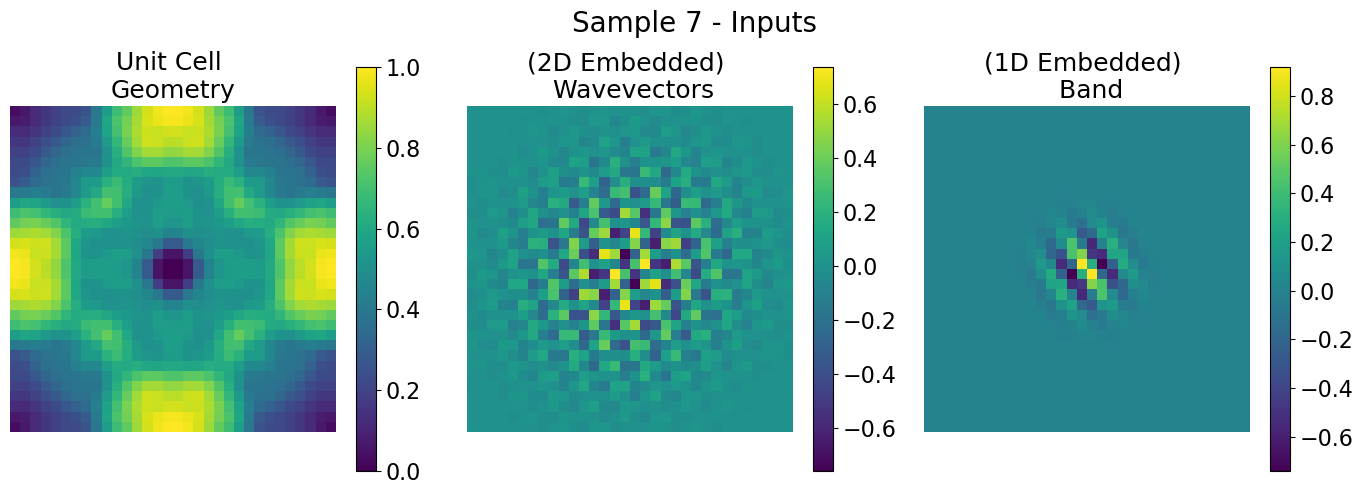

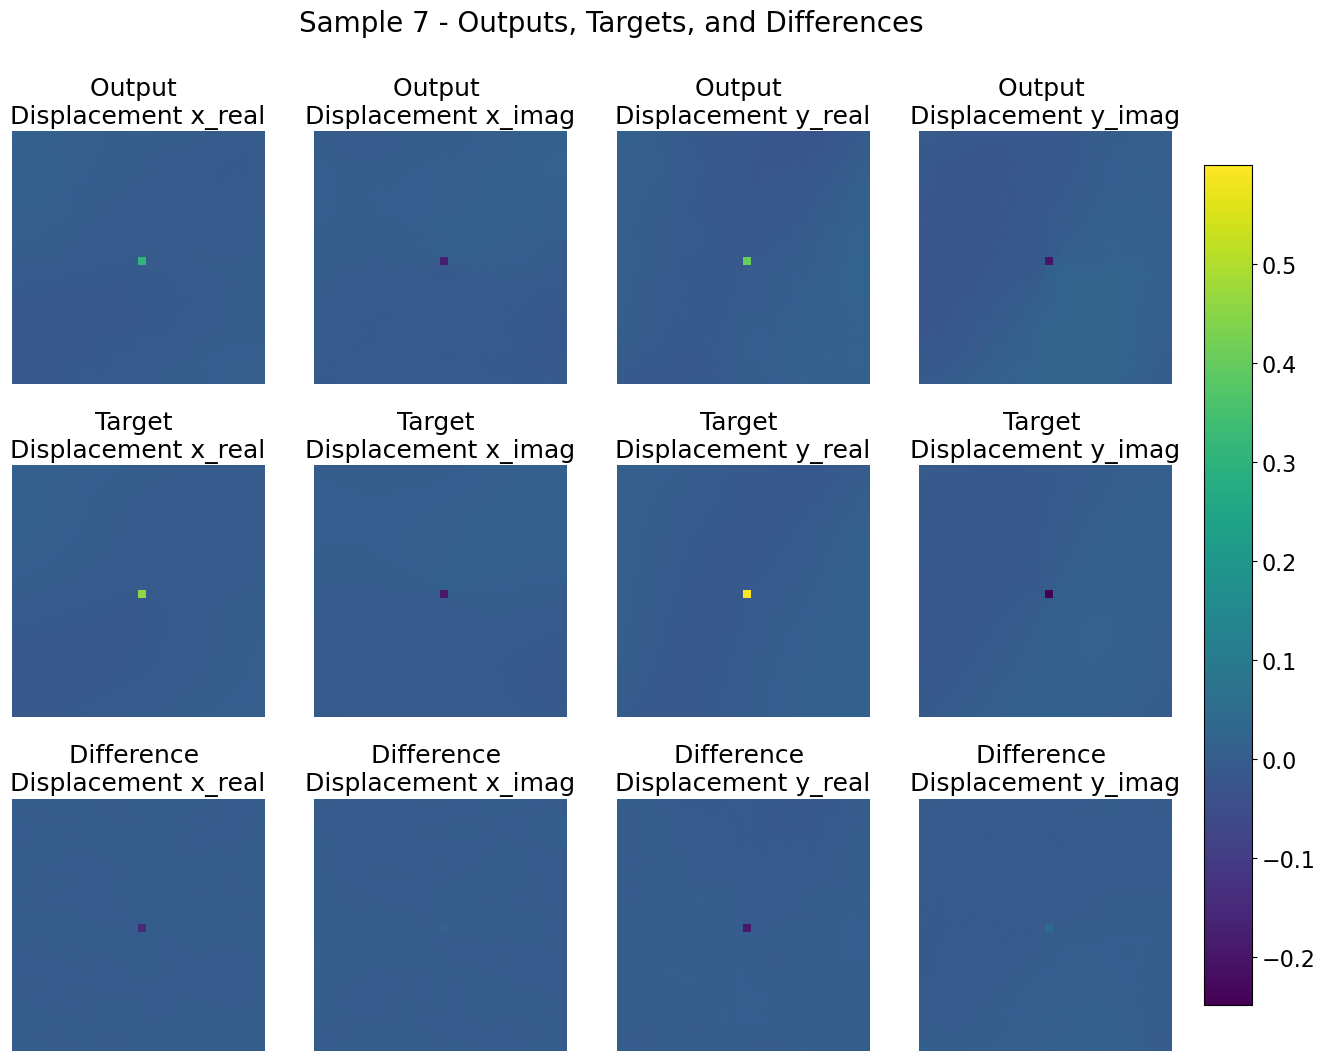

Visualizing sample 8 (index 202071)


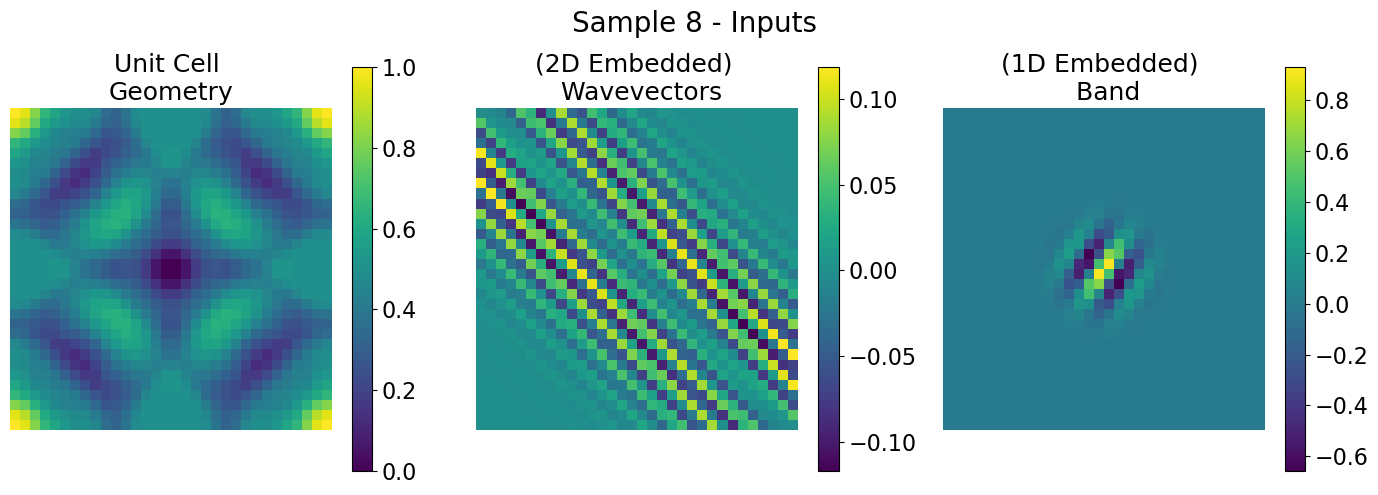

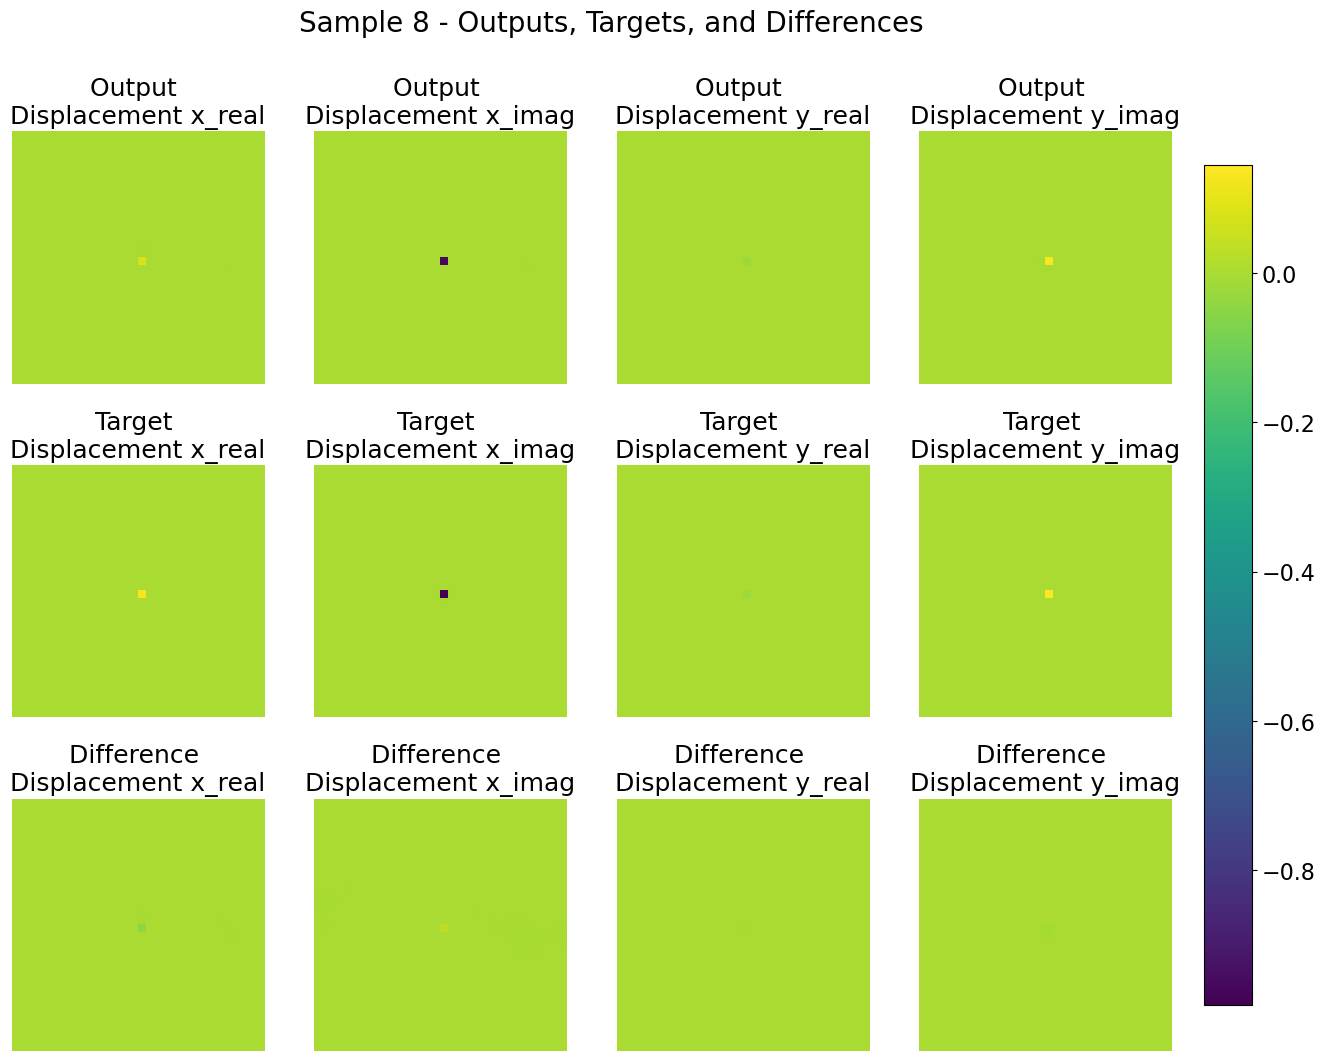

Visualizing sample 9 (index 94370)


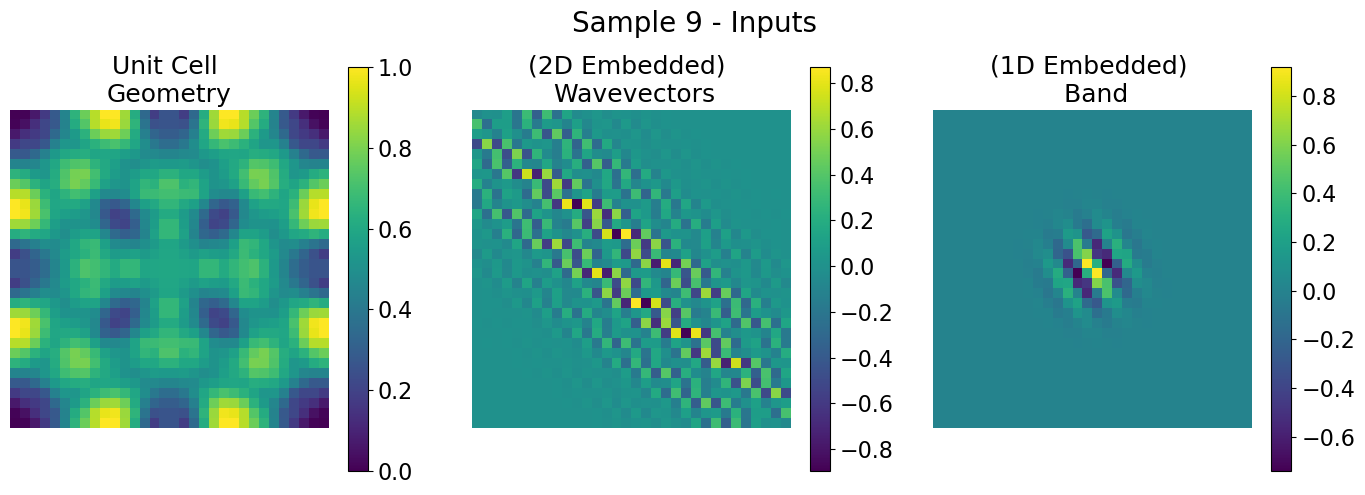

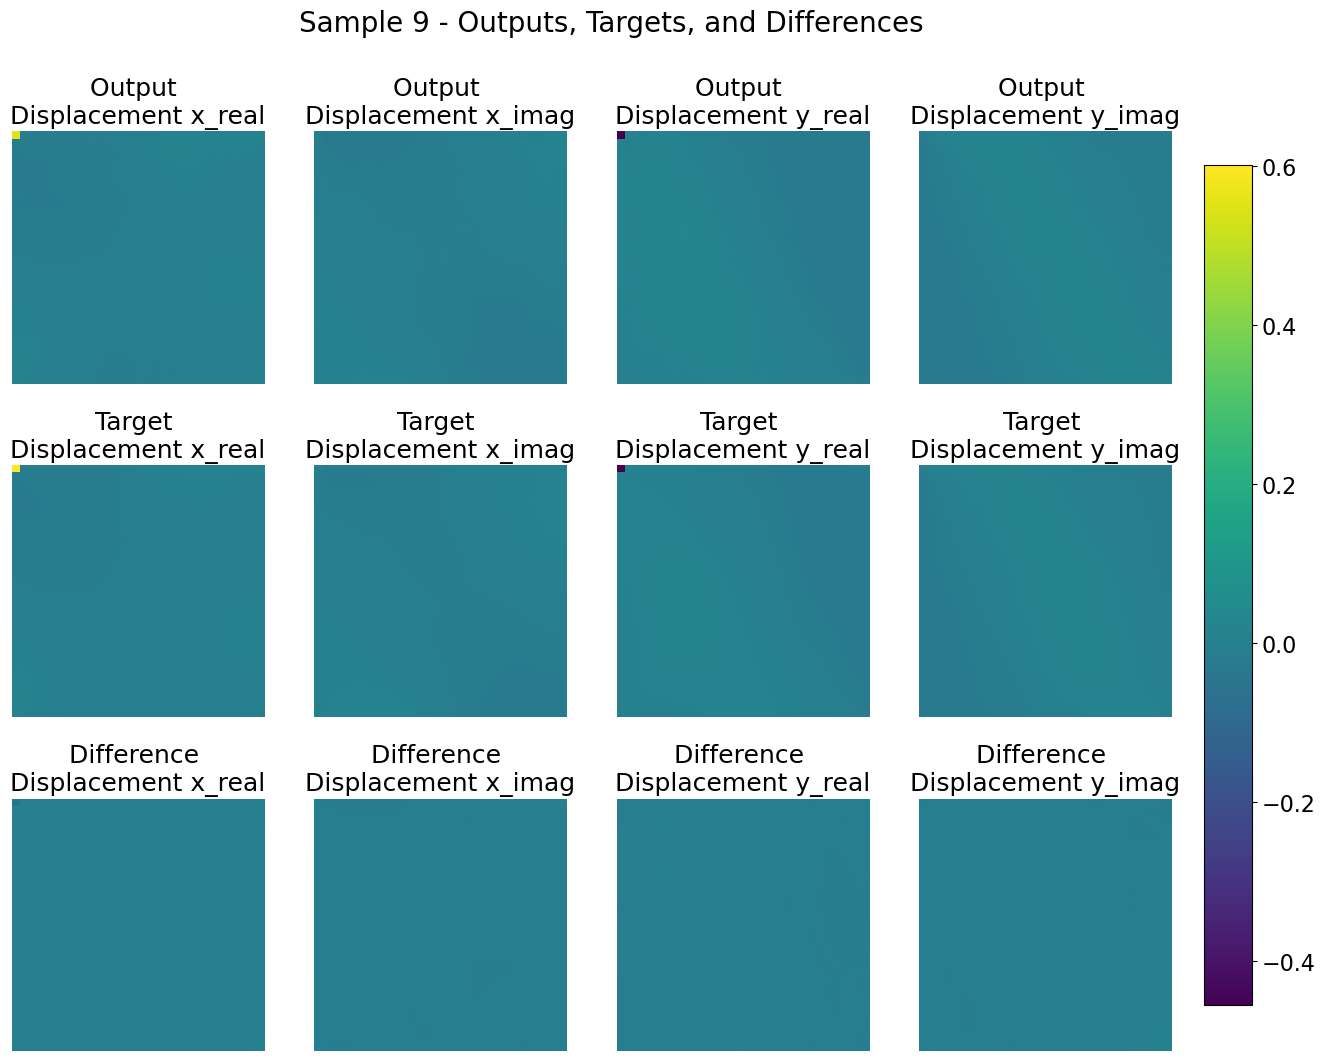

In [11]:
for i, sample_idx in enumerate(random_indices):
    print(f"Visualizing sample {i} (index {sample_idx})")
    
    # Get the stored data from the earlier processing
    input_sample = all_inputs[i]  # [3, 32, 32]
    output_sample = all_predictions[i]  # [4, 32, 32] 
    target_sample = all_targets[i]  # [4, 32, 32]
    
    # Convert to numpy for plotting
    input_sample = input_sample.numpy()
    output_sample = output_sample.numpy()
    target_sample = target_sample.numpy()
    
    # Plot the 3 inputs in a 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    fig.suptitle(f'Sample {i} - Inputs', fontsize=20)
    
    input_titles = ['Unit Cell \nGeometry', '(2D Embedded) \n Wavevectors', '(1D Embedded) \n Band']
    
    for j in range(3):
        im = axes[j].imshow(input_sample[j], cmap='viridis')
        axes[j].set_title(input_titles[j], fontsize=18)
        axes[j].axis('off')
        cbar = plt.colorbar(im, ax=axes[j])
        cbar.ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    plt.show()
    
    # Plot outputs, targets, and differences in a 3x4 subplot with shared colorbar
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Sample {i} - Outputs, Targets, and Differences', fontsize=20)
    
    # Channel labels
    channel_labels = ["Displacement x_real", "Displacement x_imag", "Displacement y_real", "Displacement y_imag"]
    
    # Find global min/max for outputs and targets to share colorbar
    output_min, output_max = output_sample.min(), output_sample.max()
    target_min, target_max = target_sample.min(), target_sample.max()
    
    # Include differences in the global min/max calculation
    diff_data = []
    for j in range(4):
        diff = output_sample[j] - target_sample[j]
        diff_data.append(diff)
    diff_min = min([d.min() for d in diff_data])
    diff_max = max([d.max() for d in diff_data])
    
    # Global min/max across all data (outputs, targets, and differences)
    global_min = min(output_min, target_min, diff_min)
    global_max = max(output_max, target_max, diff_max)
    
    # Row 1: Outputs
    for j in range(4):
        im = axes[0, j].imshow(output_sample[j], cmap='viridis', vmin=global_min, vmax=global_max)
        axes[0, j].set_title(f'Output \n{channel_labels[j]}', fontsize=18)
        axes[0, j].axis('off')
    
    # Row 2: Targets
    for j in range(4):
        im = axes[1, j].imshow(target_sample[j], cmap='viridis', vmin=global_min, vmax=global_max)
        axes[1, j].set_title(f'Target \n{channel_labels[j]}', fontsize=18)
        axes[1, j].axis('off')
    
    # Row 3: Differences (Output - Target)
    for j in range(4):
        diff = output_sample[j] - target_sample[j]
        im = axes[2, j].imshow(diff, cmap='viridis', vmin=global_min, vmax=global_max)
        axes[2, j].set_title(f'Difference \n{channel_labels[j]}', fontsize=18)
        axes[2, j].axis('off')
    
    # Adjust layout to make room for colorbar
    plt.subplots_adjust(right=0.85, hspace=0.3)
    
    # Add single shared colorbar on the right side
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    #cbar.set_label('Values', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    plt.show()
